## INTRODUCCIÓN

En nuestra empresa emergente de productos alimenticios, la comprensión del comportamiento del usuario es crucial para optimizar la experiencia en nuestra aplicación y, en última instancia, aumentar las conversiones y la satisfacción del cliente. Este proyecto se centrará en dos áreas clave: 
* El análisis del embudo de ventas para identificar cómo los usuarios y las usuarias navegan a través de las diferentes etapas hasta llegar a la compra.

* La evaluación de un test A/A/B en donde los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas todo esto para considerar un cambio de diseño propuesto sin tomar tantos riesgos.

## RUTA DE ACTIVIDADES

Durante el desarrollo de nuestro proyecto y con el fin de mantener un orden y mejor entendimiento del mismo, lo dividiremos en las siguientes fases:

      1: Importación de librerias
      2: Importación de archivos
      3: Preprocesamiento de los datos
      4: Ingeniería de características
      5: Estudiar y comprobar los datos
      6: Análisis del embudo de ventas
      7: Evaluación de la prueba A/A/B
      8: Conclusión general

## IMPORTACIÓN DE LIBRERIAS

In [1]:
#Importación de las librerias con las que trabajaremos el proyecto.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
from math import factorial
import plotly.express as px
from plotly import graph_objects as go
from datetime import datetime
from scipy.stats import chi2_contingency

## IMPORTACIÓN DE ARCHIVOS

Importaremos el data frame en donde se encuentra toda la información sobre los eventos.

In [2]:
#Importar el archivo
events = pd.read_csv('/datasets/logs_exp_us.csv', sep = '\t')

Ahora es conveniente imprimir una porción de los datos para obtener una visión más clara de lo que tenemos.

In [3]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Una vez realizado esto, podemos imprimir una porción de los datos para tener una mejor visión de la información disponible.

In [4]:
#Mostrar 5 primeras filas del dataframe 'events'
events.head()

EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248

## PREPROCESAMIENTO DE DATOS

Como podemos observar en la información general no tenemos valores nulos en ninguna de las columnas, sin embargo, hay varias observaciones que debemos procesar para corregirlas:

        1. Cambiar el nombre de las columnas por unos en minúsculas y con mayor claridad.
        2. Modificar los tipos de datos de las columnas
        3. Procesar valores duplicados
        4. Verificar que no existan usuarios en más de un experimento.

### Modificar nombre de columnas

Los nombres de las columnas actuales complican la codificación, además de no representar de manera clara la información del atributo y tienen un formato incorrecto, es por eso que debemos cambiarlos.

In [5]:
#Cambiar nombre de las columnas
events.rename(columns = {'EventName':'event', 'DeviceIDHash':'user_id','EventTimestamp':'timestamp', 'ExpId':'exp_id' }, 
             inplace = True)

#Mostrar nuevo dataframe
events.sample(15)

event              user_id   timestamp  exp_id
153599       OffersScreenAppear    91292479590032512  1565002409     246
5610           MainScreenAppear  4945546033740060505  1564637713     247
34186        OffersScreenAppear  7754794048474479150  1564684493     248
90644          MainScreenAppear  1668146608972887617  1564834913     247
140422         MainScreenAppear  4619061466701287834  1564955913     247
118643         CartScreenAppear  4827377269497927948  1564914300     246
72801          MainScreenAppear  5377830222122315337  1564778335     248
84062   PaymentScreenSuccessful  4451341302339403128  1564825297     246
119931  PaymentScreenSuccessful  3521696259961091617  1564916237     248
228611         CartScreenAppear  3610536745613892312  1565183153     248
123396  PaymentScreenSuccessful  4713748699910253089  1564921527     248
145187         MainScreenAppear  7751176839309509215  1564986654     248
94418   PaymentScreenSuccessful  4623191541214045580  1564841272     247
236223       OffersScreenAppear  8160667040437994655  1565194384     248
219486         MainScreenAppear  7181739952190978476  1565165008     246

## Modificar tipos de datos

Las columna 'user_id' tiene u  tipo de dato incorrecto y tiene algunos espacios en blanco, 'exp_id' tiene tipo de datos incorrecto y 'timestamp' se encuentra en formato UTC, por lo que debemos convertirlo a un formato legible de fecha.

In [6]:
#Quitar espacios en blanco para 'user_id'
events['event'] = events['event'].str.strip()

#Modificar tipo de datos en 'user_id'
events['user_id'] = events['user_id'].astype('str')

#Quitar espacios en blanco para 'user_id'
events['user_id'] = events['user_id'].str.strip()

#Modificar tipo de datos en 'exp_id'
events['exp_id'] = events['exp_id'].astype('object')

#Modificar formato de tiempo en 'timestamp' (cambiar de 'UTC' a formato de fecha)
events['timestamp'] = events['timestamp'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

#Modificar tipo de datos en 'timestamp'
events['timestamp'] = pd.to_datetime(events['timestamp'])

Para verificar la inforamción se modificó correctamente echemos un vistazo a la información general del dataframe

In [7]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      244126 non-null  object        
 1   user_id    244126 non-null  object        
 2   timestamp  244126 non-null  datetime64[ns]
 3   exp_id     244126 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 7.5+ MB


Una vez verificados nuestros cambios, procesemos los datos duplicados. Como primer paso debemos analizar cuantas filas duplicadas tenemos.

In [8]:
#Imprimir cantidad de filas duplicadas
print('La cantidad de filas duplicadas es:', events.duplicated().sum())

La cantidad de filas duplicadas es: 413


Podemos observar que si tenemos filas duplicadas, lo cual puede afectar nuestro análisis, sin embargo, antes de eliminarlas debemos confirmar que en realidad sean filas exactamente iguales.

In [9]:
#Filtrar dataframe con los valores duplicados y manteniendo las apariciones de las mismas
events[events.duplicated(keep = False)]

event              user_id           timestamp  \
452            MainScreenAppear  5613408041324010552 2019-07-30 08:19:44   
453            MainScreenAppear  5613408041324010552 2019-07-30 08:19:44   
2348           CartScreenAppear  1694940645335807244 2019-07-31 21:51:39   
2350           CartScreenAppear  1694940645335807244 2019-07-31 21:51:39   
3572           MainScreenAppear   434103746454591587 2019-08-01 02:59:37   
...                         ...                  ...                 ...   
242359  PaymentScreenSuccessful  2382591782303281935 2019-08-07 19:27:29   
242360  PaymentScreenSuccessful  2382591782303281935 2019-08-07 19:27:29   
242362         CartScreenAppear  2382591782303281935 2019-08-07 19:27:29   
242634         MainScreenAppear  4097782667445790512 2019-08-07 19:36:58   
242635         MainScreenAppear  4097782667445790512 2019-08-07 19:36:58   

       exp_id  
452       248  
453       248  
2348      248  
2350      248  
3572      248  
...       ...  
242359    246  
242360    246  
242362    246  
242634    246  
242635    246  

[768 rows x 4 columns]

Una vez confirmado que si son exactamente iguales, tenemos que eliminarlas:

In [10]:
#Eliminar filas duplicadas
events.drop_duplicates(inplace = True)

Confirmemos que ya no tenemos filas duplicadas:

In [11]:
#Imprimir cantidad de filas duplicadas
print('La cantidad de filas duplicadas es:', events.duplicated().sum())

La cantidad de filas duplicadas es: 0


Dado que la propia naturaleza de la información de las columnas permite duplicidad de valores, no podemos eliminarlos, por lo que nuestro procesamientod de valores duplicados explícitos está terminado. Ahora debemos asegurar la ausencia de valores duplicados implicitos.

In [12]:
#Datos duplicados implícitos
rows = events.shape[0]
unique_values = events['event'].nunique()

if rows  == unique_values:
    print('No hay valores duplicados implícitos')
else:
    print('Verifique los valores unicos')
    print(events['event'].unique())

Verifique los valores unicos
['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


Al evaluar los valores 'unicos dentro de la columna 'event' podemos asegurar que no tenemos datos duplicados de forma implicita en esta columna, que es la más propensa a tenerlos.

### USUARIOS EN VARIOS EXPERIMENTOS

Como primer paso debemos generar tres variables donde se almacenen los dataframe filtrados para cada uno de los experimentos.

In [13]:
#Dataset para las ordenes pertenecientes al experimento 246
exp_246 = events[events['exp_id']=='246']

#Dataset para las ordenes pertenecientes al experimento 247
exp_247 = events[events['exp_id']=='247']

#Dataset para las ordenes pertenecientes al experimento 248
exp_248 = events[events['exp_id']=='248']

Ahora debemos convertir la columna 'user_id' al tipo 'set' para poder verificar si hay elementos en común con métodos de intersección para confirmar si existen o no, usuarios en varios experimentos.

In [14]:
# Convertimos las listas a conjuntos (sets)
set_grupo1 = set(exp_246['user_id'])
set_grupo2 = set(exp_247['user_id'])
set_grupo3 = set(exp_248['user_id'])

# Verificamos si hay elementos en común entre los conjuntos
interseccion_1_2 = set_grupo1.intersection(set_grupo2)
interseccion_1_3 = set_grupo1.intersection(set_grupo3)
interseccion_2_3 = set_grupo2.intersection(set_grupo3)

# Imprimimos los resultados
print("Usuarios en común entre grupo 1 y grupo 2:", interseccion_1_2)
print("Usuarios en común entre grupo 1 y grupo 3:", interseccion_1_3)
print("Usuarios en común entre grupo 2 y grupo 3:", interseccion_2_3)

# Verificamos si no hay elementos en común
if not interseccion_1_2 and not interseccion_1_3 and not interseccion_2_3:
    print("No hay usuarios en múltiples grupos.")
else:
    print("Hay usuarios en múltiples grupos.")

Usuarios en común entre grupo 1 y grupo 2: set()
Usuarios en común entre grupo 1 y grupo 3: set()
Usuarios en común entre grupo 2 y grupo 3: set()
No hay usuarios en múltiples grupos.


Ya que sabemos que no tenemos usuarios en varios experimentos, podemos proceder con la siguiente fase del proyecto.

## INGENIERÍA DE CARACTERÍSTICAS

Para nuestro análisis será conveniente generar una columna donde almacenemos la fecha de los eventos y otra en donde solamente se almacene la hora.

In [15]:
#Crear columna para la fecha del evento
events['event_date'] = events['timestamp'].dt.date

#Convertir al tipo 'datetime'
events['event_date'] = pd.to_datetime(events['event_date'])

#Crear columna para la hora del evento
events['event_hour'] = events['timestamp'].dt.time

#Mostrar 5 primeras filas del dataframe 
events.head()

event              user_id           timestamp exp_id  \
0         MainScreenAppear  4575588528974610257 2019-07-25 04:43:36    246   
1         MainScreenAppear  7416695313311560658 2019-07-25 11:11:42    246   
2  PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47    248   
3         CartScreenAppear  3518123091307005509 2019-07-25 11:28:47    248   
4  PaymentScreenSuccessful  6217807653094995999 2019-07-25 11:48:42    248   

  event_date event_hour  
0 2019-07-25   04:43:36  
1 2019-07-25   11:11:42  
2 2019-07-25   11:28:47  
3 2019-07-25   11:28:47  
4 2019-07-25   11:48:42

## ESTUDIAR Y COMPROBAR LOS DATOS

### ¿Cuántos eventos hay en los registros?

In [16]:
#Mostrar la cantidad de eventos y filas en el dataframe
print('La cantidad de registros es de:', events.shape[0], 'en los cuales solamente existen',
      events['event'].nunique(), 'eventos diferentes:', '\n', events['event'].unique())

La cantidad de registros es de: 243713 en los cuales solamente existen 5 eventos diferentes: 
 ['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


### ¿Cuántos usuarios hay en los registros?

In [17]:
#Conteo de usuarios
users_cnt = events['user_id'].nunique()

#Imprimir la cantidad de usuarios en los registros
print('La cantidad total de usuarios registrados es de:', users_cnt)

La cantidad total de usuarios registrados es de: 7551


### ¿Cuál es el promedio de eventos por usuario?

In [18]:
#Calcular la cantidad de eventos por usuario
users_events_cnt = events.groupby('user_id' , as_index = False).agg({'event':'count'})

#Renombrar columna
users_events_cnt.rename(columns = {'event':'total_events'}, inplace = True)

#Caluclar el promedio de eventos por usuario
users_events_mean = users_events_cnt['total_events'].mean().round()

#Imprimir cantidad promedio de eventos por usuario
print('En promedio, los usuarios realizan una cantidad de', users_events_mean, 'eventos')

En promedio, los usuarios realizan una cantidad de 32.0 eventos


### ¿Qué periodo de tiempo cubren los datos?

Primero identifiquemos el rango de fechas en los que se encuentran nuestros registros

In [19]:
#Mostrar resumen de la columna 'events_date'
events['event_date'].describe()

count                  243713
unique                     14
top       2019-08-01 00:00:00
freq                    36141
first     2019-07-25 00:00:00
last      2019-08-07 00:00:00
Name: event_date, dtype: object

Parece que nuestro rango va desde el 2019-07-25 al 2019-08-07 dando un total de 14 días de información. Ahora creemos un histograma para visualizar como se distribuyen nuestros datos alrededor de éstas fechas.

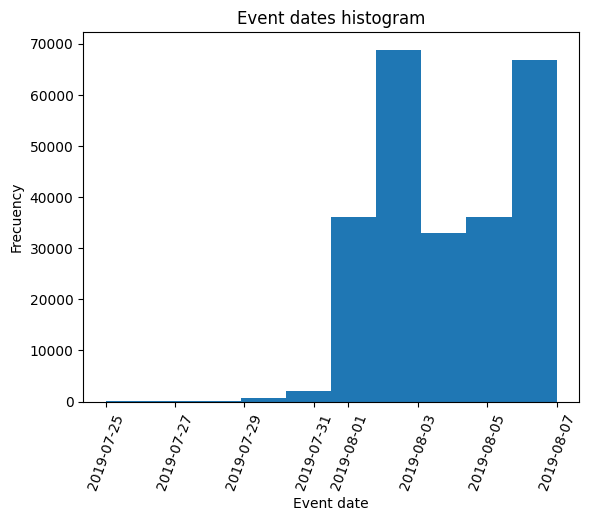

In [20]:
#Crear histograma
plt.hist(events['event_date'])

#Rotación de las etiquetas del eje 'x'
plt.xticks(rotation = 70)

#Etiqueta eje x
plt.xlabel("Event date")

#Etiqueta eje y 
plt.ylabel("Frecuency")

#Título del gráfico
plt.title("Event dates histogram")

#Mostrar gráfico
plt.show()

Visto que los datos comienzan a tener una cantidad realmente significativa a partir del '2019-08-01'por lo que los días anteriores se eliminarán para evitar sesgos en nuestro análisis.

In [21]:
#Filtrar los datos a partir del '2019-08-01'
events_filtered = events[(events['event_date'] >= '2019-08-01')]

#Mostrar resumen de la fila de fecha para confirmar filtro
events_filtered['event_date'].describe()

count                  240887
unique                      7
top       2019-08-01 00:00:00
freq                    36141
first     2019-08-01 00:00:00
last      2019-08-07 00:00:00
Name: event_date, dtype: object

Podemos observar que ahora nustro rango de fechas va desde el '2019-08-01' hasta el '2019-08-07'. Ahora veamos cuantos dados hemos eliminado y no serán considerados en el análisis, así como la cantidad de usuarios excluidos.

In [22]:
#Calcular la cantidad de registros eliminados
excluded_data = events['event_date'].count() - events_filtered['event_date'].count() 

#Mostrar el número de registros excluidos
print('Los registros excluidos debido al filtro de fechas da un total de:', excluded_data)

#Caclular el número de usuarios excluidos
excluded_users = events['user_id'].nunique() - events_filtered['user_id'].nunique() 


#Mostrar el número de registros excluidos
print('Los usuarios excluidos debido al filtro de fechas da un total de:', excluded_users)

Los registros excluidos debido al filtro de fechas da un total de: 2826
Los usuarios excluidos debido al filtro de fechas da un total de: 17


Ahora aseguremonos de que tengamos información para todas los experimentos.

In [23]:
#Mostrar la cantidad de veces que aparece cada experimento después del filtro
events_filtered['exp_id'].value_counts()

248    84563
246    79302
247    77022
Name: exp_id, dtype: int64

Tenemos suficiente información sobre los experimentos, por lo tanto, es posible continuar con el análisis de embudo.

## ANÁLISIS DEL EMBUDO DE VENTAS

### Frecuencia de cada evento

In [24]:
#Agrupar por eventos y realizar el conteo de aparición de cada uno
events_freq = events_filtered.groupby('event', as_index = False).agg(event_cnt=('event', 'count'),
                                                                    user_cnt=('user_id', 'nunique')).sort_values('event_cnt',
                                                                                                        ascending = False)
#Resetear índices
events_freq.reset_index(drop = True, inplace = True)

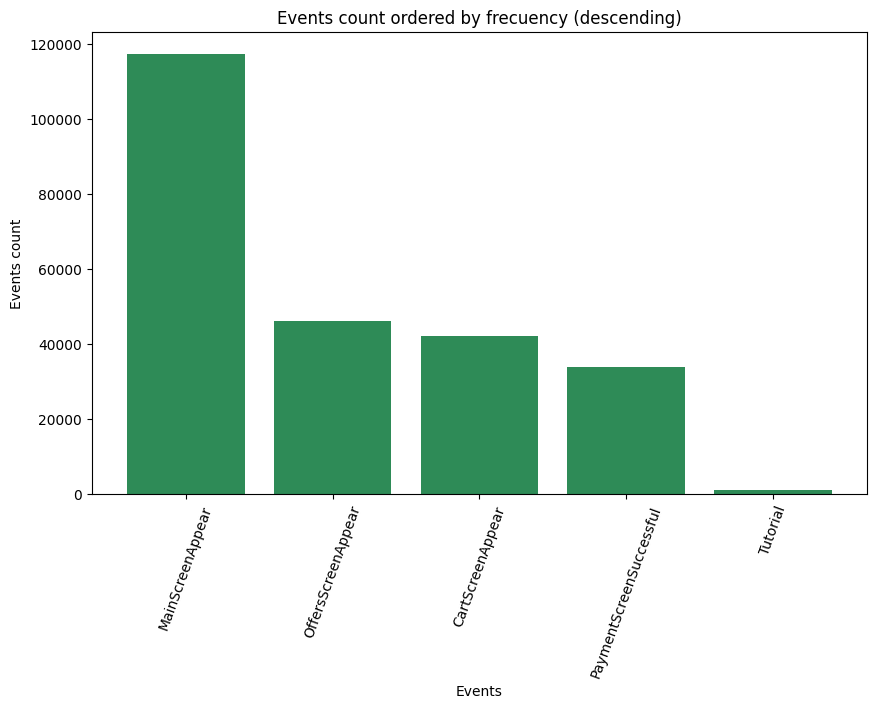

In [25]:
#Crear gráfico de barras para visualizar la freceuncia de los eventos
#Definición del tamaño para el gráfico
plt.figure(figsize = (10,6))

#Generación del histograma
plt.bar(events_freq['event'] , events_freq['event_cnt'], color = 'seagreen')

#Etiqueta para el eje x
plt.xlabel('Events')

#Etiqueta para el eje y
plt.ylabel('Events count')

#Titulo del gráfico
plt.title('Events count ordered by frecuency (descending)')

#Rotación de las etiquetas del eje x
plt.xticks(rotation = 70)

#Mostrar gráfico
plt.show()

Como podemos observar, el evento con menos registros es el tutorial, lo que puede darnos a entender que no muchas personas le prestan atención al mismo, sin embargo, tenemos lo contrario para 'MainScreenAppear' lo que nos habla de que los usuarios entran directamente a la página principal. 

### Cantidad de usuarios únicos para cada evento

Analicemos cuantos usuarios han participado en cada evento sin contar los repetidos:

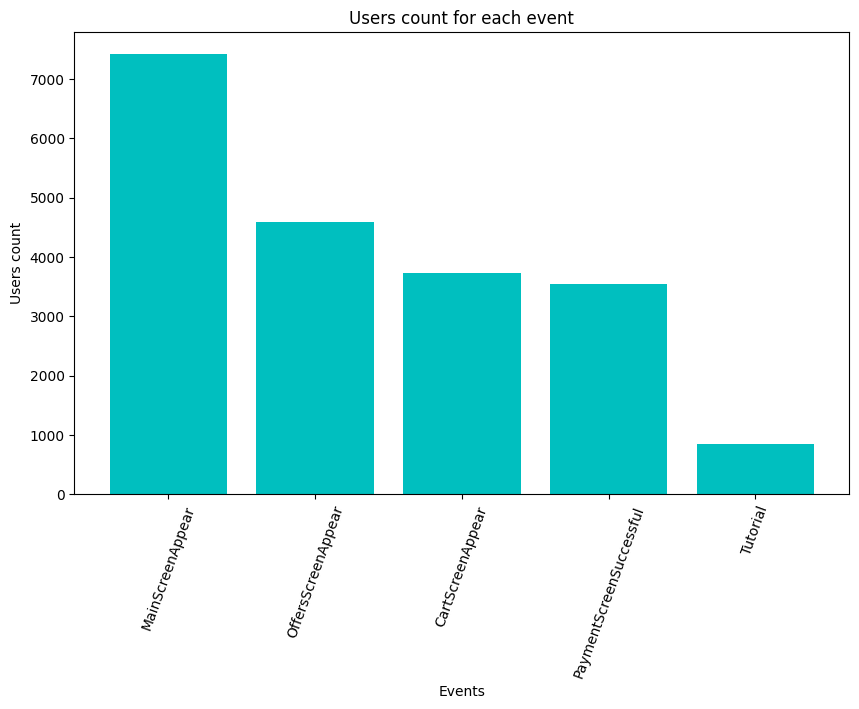

In [26]:
#Graficar cantidad de usuarios que realizaron cada evento
#Definición del tamaño para el gráfico
plt.figure(figsize = (10,6))

#Generación del histograma
plt.bar(events_freq['event'] , events_freq['user_cnt'], color = 'c')

#Etiqueta para el eje x
plt.xlabel('Events')

#Etiqueta para el eje y
plt.ylabel('Users count')

#Titulo del gráfico
plt.title('Users count for each event')

#Rotación de las etiquetas del eje x
plt.xticks(rotation = 70)

#Mostrar gráfico
plt.show()

Como podemos observar, ambos gráficos tienen el mismo comportamiento, por lo que podemos concluir que es probable que  mientras más registros tenga cada uno de los eventos (frecuencia) mayores usuarios 'unicos' lo habrán realizado al menos una vez.

### Proporción de usuarios con una sola acción por evento

In [27]:
#Dataframe agrupado por usuario y por cada evento
user_events = events_filtered.groupby(['user_id','event'], as_index = False).agg(user_cnt = ('user_id', 'count'), timestamp=('timestamp', 'first'))

#Cantidad de usuarios con un registro en 'Tutorial'
tut_users = user_events[(user_events['user_cnt'] == 1) & (user_events['event'] == 'Tutorial')].shape[0]

#Cantidad de usuarios con un registro en 'MainScreenAppear'
msa_users = user_events[(user_events['user_cnt'] == 1) & (user_events['event'] == 'MainScreenAppear')].shape[0]

#Cantidad de usuarios con un registro en 'OffersScreenAppear'
osa_users = user_events[(user_events['user_cnt'] == 1) & (user_events['event'] == 'OffersScreenAppear')].shape[0]

#Cantidad de usuarios con un registro en 'CartScreenAppear'
csa_users = user_events[(user_events['user_cnt'] == 1) & (user_events['event'] == 'CartScreenAppear')].shape[0]

#Cantidad de usuarios con un registro en 'PaymentScreenSuccessful'
pss_users = user_events[(user_events['user_cnt'] == 1) & (user_events['event'] == 'PaymentScreenSuccessful')].shape[0]

In [28]:
#Crear nueva columna para la proporción de usuarios con una sola accion en cada evento
for index, row in events_freq.iterrows():
    if row['event'] == 'Tutorial':
        events_freq.loc[index, 'one_action_rate'] = tut_users / row['user_cnt']
        
    elif row['event'] == 'MainScreenAppear':
        events_freq.loc[index, 'one_action_rate'] = msa_users / row['user_cnt']
        
    elif row['event'] == 'OffersScreenAppear':
        events_freq.loc[index, 'one_action_rate'] = osa_users / row['user_cnt']
        
    elif row['event'] == 'CartScreenAppear':
        events_freq.loc[index, 'one_action_rate'] = csa_users / row['user_cnt']
        
    elif row['event'] == 'PaymentScreenSuccessful':
        events_freq.loc[index, 'one_action_rate'] = pss_users / row['user_cnt']
        
#Mostrar dataframe para confirmar cambios 
events_freq

event  event_cnt  user_cnt  one_action_rate
0         MainScreenAppear     117328      7419         0.033158
1       OffersScreenAppear      46333      4593         0.148269
2         CartScreenAppear      42303      3734         0.126406
3  PaymentScreenSuccessful      33918      3539         0.162193
4                 Tutorial       1005       840         0.900000

In [29]:
# Definir los colores que deseas usar
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974']

#Gráfico circular para mostrar las proporciones
fig = go.Figure(data = [go.Pie(labels = events_freq['event'], 
                               values = events_freq['one_action_rate'],
                              marker=dict(colors=colors))])

#Mostrar gráfico
fig.show()

El gráfico muestra que el evento con un mayor número de usuarios que solamente lo realizan una vez es el Tutorial, a pesar de que no muchos usuarios suelen tomarlo (según los gráficos de frecuencia) lo cual indica que las personas que lo toman son capaces de aprender rapidamente y a la primera como navegar por nuestra página web. Sin embargo, la pantalla de pago es el segundo con éste tipo de incidencias, lo cual nos permite sospechar de que la gente no está volviendo a comprar en nuestra página después de la primera vez.

### ¿En que orden ocurrieron las acciones?

In [30]:
#Ordenar valores cronológicamente
cron_events = user_events.sort_values(['timestamp','user_cnt'])

cron_events

user_id                    event  user_cnt  \
6358  3737462046622621720                 Tutorial         2   
6355  3737462046622621720         MainScreenAppear        14   
6356  3737462046622621720       OffersScreenAppear        12   
888   1433840883824088890         MainScreenAppear        45   
9286  4899590676214355127         MainScreenAppear        47   
...                   ...                      ...       ...   
7376  4164287718073415198  PaymentScreenSuccessful         1   
7373  4164287718073415198         CartScreenAppear         2   
5658  3454683894921357834         MainScreenAppear         6   
5657  3454683894921357834         CartScreenAppear         2   
4627  3014810502934076967       OffersScreenAppear         3   

               timestamp  
6358 2019-08-01 00:07:28  
6355 2019-08-01 00:08:00  
6356 2019-08-01 00:08:58  
888  2019-08-01 00:08:59  
9286 2019-08-01 00:10:15  
...                  ...  
7376 2019-08-07 20:41:36  
7373 2019-08-07 20:41:36  
5658 2019-08-07 20:43:30  
5657 2019-08-07 20:44:29  
4627 2019-08-07 21:03:03  

[20125 rows x 4 columns]

In [31]:
# Concatenar los eventos en una secuencia para cada usuario
user_events['event_sequence'] = user_events.groupby('user_id')['event'].transform(lambda x: '-'.join(x))

# Eliminar duplicados para obtener una secuencia por usuario
cron_events_seq = user_events.drop_duplicates(subset=['user_id', 'event_sequence'])

# Contar las secuencias más comunes
sequence_counts = cron_events_seq['event_sequence'].value_counts()

# Mostrar la secuencia más común
most_common_sequence = sequence_counts.idxmax()

#Frecuencia de la secuencia más común
most_common_sequence_freq = sequence_counts.max()

print(f"La secuencia más común es: {most_common_sequence}")
print(f"Frecuencia: {most_common_sequence_freq}")

La secuencia más común es: CartScreenAppear-MainScreenAppear-OffersScreenAppear-PaymentScreenSuccessful
Frecuencia: 2963


Podemos darnos cuenta que la mayoría de nuestros usuarios están comenzando su visita a la página en su carrito (seguramente debido a alguna notificacipon recibida), vuelven a la página principal para buscar ofertas y posteriormente vovler a comprar, lo cual es algo favorable en el comportamiento de los usuarios. Éste análisis  adicionado al anterior, nos indica que los usuarios que nos compran buscan las ofertas, sin embargo, no vuelven a comprar debido al alto número de registros únicos que tenemos en la página de pago exitoso.

### Porcentajes de conversión etapa por etapa

Para conocer los procentajes de personas que pasan a cada etapa debemos generar un gráfico de embudo para tener mejor la visualización de como se están distribuyendo, mientras menores sean las diferencias entre cada una de los eventos, mejor.

In [32]:
# Filtrar los eventos para excluir 'Tutorial'
funnel_events = events_freq[events_freq['event'] != 'Tutorial']

# Crear gráfico de embudo
fig = go.Figure(go.Funnel(
    y = funnel_events['event'],
    x = funnel_events['user_cnt']
))

# Mostrar gráfico
fig.show()

Ahora debemos crear una columna con los porcentajes de conversión total y la conversión a la siguiente etapa para visualizarlos de mejor manera.

In [33]:
# Inicializar la nueva columna con valores NaN
funnel_events['stages_conversion_rate'] = float('NaN')

# Calcular el porcentaje de conversión usando un ciclo for
for i in range(1, len(funnel_events)):
    funnel_events.loc[i, 'stages_convertion_rate'] = funnel_events.loc[i, 'user_cnt'] / funnel_events.loc[i-1, 'user_cnt']
    
#Calcular el porcentaje de conversión total usando un ciclo for
for i in range(1, len(funnel_events)):
    funnel_events.loc[i, 'total_convertion_rate'] = funnel_events.loc[i, 'user_cnt'] / funnel_events.loc[0, 'user_cnt']

# Reemplazar NaN en la columna 'conversion_rate' con 1.00
funnel_events['stages_convertion_rate'].fillna(1.00, inplace=True)

# Reemplazar NaN en la columna 'total_conversion_rate' con 1.00
funnel_events['total_convertion_rate'].fillna(1.00, inplace=True)

#Mostrar dataframe actualizado
funnel_events

/tmp/ipykernel_81/2688927834.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/envs/python3/lib/python3.9/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/envs/python3/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

event  event_cnt  user_cnt  one_action_rate  \
0         MainScreenAppear     117328      7419         0.033158   
1       OffersScreenAppear      46333      4593         0.148269   
2         CartScreenAppear      42303      3734         0.126406   
3  PaymentScreenSuccessful      33918      3539         0.162193   

   stages_conversion_rate  stages_convertion_rate  total_convertion_rate  
0                     NaN                1.000000               1.000000  
1                     NaN                0.619086               0.619086  
2                     NaN                0.812976               0.503302  
3                     NaN                0.947777               0.477018

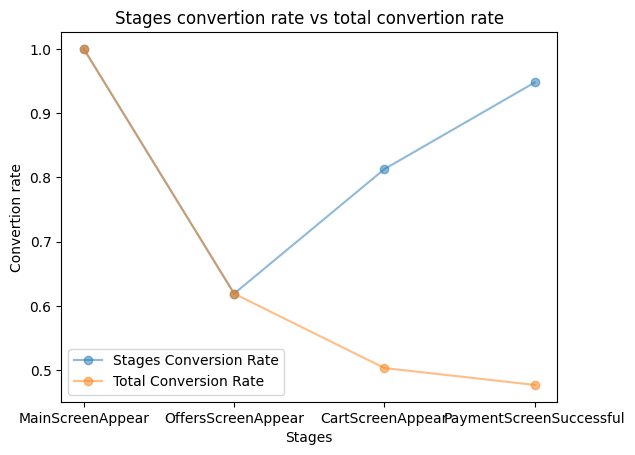

In [34]:
#Variables a usar en el gráfico
stages = funnel_events['event']
conversion_rate = funnel_events['stages_convertion_rate']
total_conversion_rate = funnel_events['total_convertion_rate']

# Crear el gráfico de líneas
plt.plot(stages, conversion_rate, marker='o', label='Stages Conversion Rate', alpha = 0.5)
plt.plot(stages, total_conversion_rate, marker='o', label='Total Conversion Rate', alpha = 0.5)
plt.xlabel('Stages')
plt.ylabel('Convertion rate')
plt.title('Stages convertion rate vs total convertion rate')
plt.legend()
plt.show()


La gráfica muestra que aproximadamente el 50% de los usuarios que visitaron la página principal continuaron hasta completar una compra exitosa (tasa de conversión total). Sin embargo, observamos una disminución significativa en la conversión entre la página principal y la página de ofertas, lo que sugiere que las ofertas pueden no ser lo suficientemente atractivas para todos los usuarios o que hay problemas en la navegación.

A partir de la página de ofertas, las tasas de conversión por etapas mejoran conforme avanzamos en el embudo, indicando que las ofertas son bien recibidas por aquellos que las ven. Sin embargo, la tasa de conversión total sugiere que algunos usuarios podrían estar experimentando problemas al pagar o no están convencidos por las ofertas, lo que los lleva a abandonar el proceso.

En resumen, es crucial investigar más a fondo las razones detrás de la baja conversión inicial y los posibles problemas en la etapa de pago para mejorar la experiencia del usuario y aumentar la tasa de conversión total.

## RESULTADOS DEL EXPERIMENTO A/A/B

### ¿Cuántos usuarios y usuarias hay en cada grupo?

In [35]:
#Mostrar la cantidad de veces que aparece cada experimento después del filtro
print('La cantidad de usuarios en cada grupo es:', '\n', events_filtered['exp_id'].value_counts())

La cantidad de usuarios en cada grupo es: 
 248    84563
246    79302
247    77022
Name: exp_id, dtype: int64


### ¿Existe diferencia significativa en la prueba A/A? (muestras 246 y 247)

Para evaluar diferencias entre las muestras 246 y 247 podemos enfocarnos en:

* Promedios de eventos: Comparar los promedios de los valores de eventos entre las dos muestras.

* Duración de la actividad: Calcular la duración de la actividad para cada usuario y compararlas entre las dos muestras.

* Tasas de conversión por etapa y total

In [36]:
#Filtrar dataframe para el experimento 246
experiment_246_df = events_filtered[events_filtered['exp_id'] == 246]

##Filtrar dataframe para el experimento 247
experiment_247_df = events_filtered[events_filtered['exp_id'] == 247]

Ahora debemos comprobar el tamaño de registros para cada uno de los experimentos:

In [37]:
# Imprimir cantidad de usuarios para el experimento 246
print('La cantidad de usuarios para el experimento 246 es de:', experiment_246_df['user_id'].nunique())

# Imprimir cantidad de usuarios para el experimento 247
print('La cantidad de usuarios para el experimento 247 es de:', experiment_247_df['user_id'].nunique())

# Calcula la diferencia porcentual en el tamaño de las muestras
diferencia_porcentual = ((1 - (experiment_246_df['user_id'].nunique() / experiment_247_df['user_id'].nunique())) * 100)

# Imprime el resultado
print('La diferencia porcentual en el tamaño de las muestras es del:', diferencia_porcentual, '%')


La cantidad de usuarios para el experimento 246 es de: 2484
La cantidad de usuarios para el experimento 247 es de: 2513
La diferencia porcentual en el tamaño de las muestras es del: 1.1539992041384783 %


#### Frecuencia  de eventos

Al no contar con la misma cantidad de datos en los dos dataframes, debemos analizar los procentajes de cada evento sobre el total de inforamción contenida en cada tabla filtrada y así determinar si existe una diferencia significativa. 

In [38]:
#Encontrar la frecuencia de eventos para el experimento 246
events_freq_246 = experiment_246_df.groupby('event', as_index = False).agg(event_cnt = ('event','count')).sort_values('event_cnt',
                                                                                                                     ascending = False)

#Encontrar la frecuencia de eventos para el experimento 247
events_freq_247 = experiment_247_df.groupby('event', as_index = False).agg(event_cnt = ('event','count')).sort_values('event_cnt',
                                                                                                                     ascending = False)

In [39]:
# Crear una tabla de contingencia
exps_info = pd.merge(events_freq_246, events_freq_247, on='event', suffixes=('_exp_246', '_exp_247'))

#Columna con porcentaje de eventos para el experimento 246
exps_info['events_percent_246'] = (exps_info['event_cnt_exp_246'] /  experiment_246_df.shape[0]) * 100

#Columna con porcentaje de eventos para el experimento 247
exps_info['events_percent_247'] = (exps_info['event_cnt_exp_247'] /  experiment_247_df.shape[0]) * 100

<Figure size 1000x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

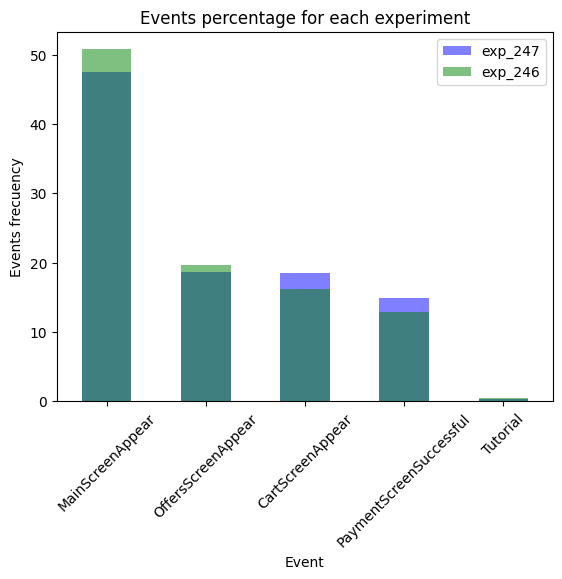

In [40]:
#Definición del tamaño para el gráfico
plt.figure(figsize = (10,6))

#Generación del gráfico
plt.figure(figsize=(12, 6))


ax = exps_info.plot(kind = 'bar', x = 'event', y = 'events_percent_246', color = 'blue', label = 'exp_247', alpha = 0.5)

exps_info.plot(kind = 'bar', x = 'event', y = 'events_percent_247', label = 'exp_246', ax = ax, color  = 'green', alpha =0.5)

plt.xlabel('Event')


plt.ylabel('Events frecuency')


plt.title('Events percentage for each experiment')


plt.xticks(rotation=45)


plt.legend(title='')


plt.show()


Como podemos observar en la gráfica, tenemos difrencias que parecieran no ser de mayor importancia, sin embargo, debemos realizar una prueba estadística para determinarlo. La prueba estadística adecuada para comparar frecuencias entre dos muestras es la prueba 'chi-cuadrado'.

En ambos experimentos, el evento más pópular es 'MainScreenAppear', tambien debemos conocer la cantidad de usuarios que tiene cada uno.

In [41]:
#Contar el número de usuarios que realizaron el evento 'MainScreenAppear' en el experimento 246
msa_cnt_246 = experiment_246_df[experiment_246_df['event'] == 'MainScreenAppear']['user_id'].nunique()

#Contar el número de usuarios que realizaron el evento 'MainScreenAppear' en el experimento 247
msa_cnt_247 = experiment_247_df[experiment_247_df['event'] == 'MainScreenAppear']['user_id'].nunique()

#Imprimir resultados para experimento 246
print('La cantidad de usuarios que realizaron el evento principal es:', msa_cnt_246)

#Imprimir resultados para experimento 247
print('La cantidad de usuarios que realizaron el evento principal es:', msa_cnt_247)

La cantidad de usuarios que realizaron el evento principal es: 2450
La cantidad de usuarios que realizaron el evento principal es: 2476


##### Prueba Chi cuadrado

In [42]:
# Crear una tabla de contingencia
contingency_table = exps_info[['events_percent_246', 'events_percent_247']]

# Realizar la prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-cuadrado: {chi2}")
print(f"p-valor: {p}")

# Interpretar el p-valor
if p < 0.05:
    print("Las diferencias en las frecuencias son estadísticamente significativas.")
else:
    print("No hay diferencias estadísticamente significativas en las frecuencias.")

Chi-cuadrado: 0.44452390805234226
p-valor: 0.978671977575312
No hay diferencias estadísticamente significativas en las frecuencias.


La prueba de chi cuadrado para las proporciones de cada evento en ambos experimentos arrojó que nuestras diferencias entre las muestras no son significativas a pesar de que la diferencia de usuarios de cada experimento sea mayor al 1%.

#### Duración de la actividad por usuario

##### Experimento 246

In [43]:
#Agrupar por cada usuario y por cada fecha para obtener cada sesion
exp_246_sessions = experiment_246_df.groupby(['user_id','event_date'], as_index = False).agg(
    min_time = ('event_hour','min'), max_time = ('event_hour','max'), exp_id = ('exp_id','max'))

#Cambiar al tipo datetime la columna 'min_time'
exp_246_sessions['max_time'] = pd.to_datetime(exp_246_sessions['max_time'], format='%H:%M:%S')

#Cambiar al tipo datetime la columna 'max_time'
exp_246_sessions['min_time'] = pd.to_datetime(exp_246_sessions['min_time'], format='%H:%M:%S')

In [44]:
#Columna con la duración de las sesiones diarias por cada usuario en el exp 246
exp_246_sessions['session_duration'] = (exp_246_sessions['max_time'] - exp_246_sessions['min_time']).dt.seconds

##### Experimento 247

In [45]:
#Agrupar por cada usuario y por cada fecha para obtener cada sesion
exp_247_sessions = experiment_247_df.groupby(['user_id','event_date'], as_index = False).agg(
    min_time = ('event_hour','min'), max_time = ('event_hour','max'), exp_id = ('exp_id','max'))

#Cambiar al tipo datetime la columna 'min_time'
exp_247_sessions['max_time'] = pd.to_datetime(exp_247_sessions['max_time'], format='%H:%M:%S')

#Cambiar al tipo datetime la columna 'max_time'
exp_247_sessions['min_time'] = pd.to_datetime(exp_247_sessions['min_time'], format='%H:%M:%S')

In [46]:
#Columna con la duración de las sesiones diarias por cada usuario en el exp 246
exp_247_sessions['session_duration'] = (exp_247_sessions['max_time'] - exp_247_sessions['min_time']).dt.seconds

##### Distribución de la duración de las sesiones en los experimentos

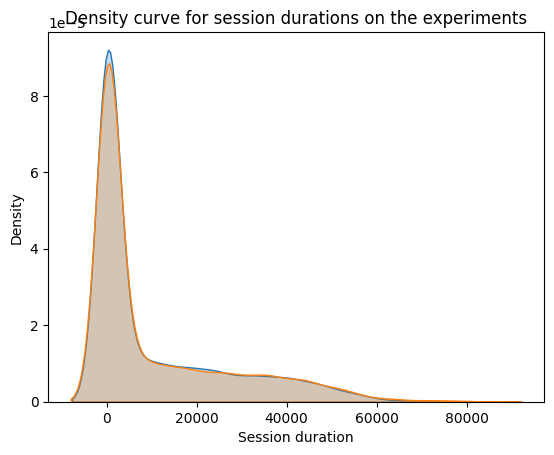

In [47]:
#Generación del histograma de densidad para el experimento 246
sns.kdeplot(exp_246_sessions['session_duration'], fill=True)

#Generación del histograma de densidad para el experimento 247
sns.kdeplot(exp_247_sessions['session_duration'], fill=True)

#Etiqueta eje x
plt.xlabel("Session duration")

#Etiqueta eje y 
plt.ylabel("Density")

#Título del gráfico
plt.title("Density curve for session durations on the experiments")

#Mostrar gráfico
plt.show()

Como podemos ver, la duración de los usuarios en las sesiones diarias es prácticamente la misma, por lo que podemos asegurar que no presentan diferencias significativas en éste comportamiento, para asegurarnos de esto podemos realizar una prueba estadística con 'ttest_ind'.

##### Prueba de Shapiro

Para asegurarnos de que las diferencias sean o no significativas primero debemos asegurar que su distribución sea del tipo normal con una prueba de Shapiro.

In [48]:
# Prueba de normalidad Shapiro-Wilk para el experimento 246
# nivel de significación
alpha = .05 

results = st.shapiro(exp_246_sessions['session_duration'].sample(5000)) 

# el segundo valor en la matriz de resultados (con índice 1) - el valor p 
p_value = results[1]

print('p-value: ', p_value) 

if (p_value < alpha): 
    print("Hipótesis nula rechazada: la distribución para el experimento 246 no es normal")
else: 
    print("No se pudo rechazar la hipótesis nula: la distribución para el experimento 246 parece ser normal")


p-value:  0.0
Hipótesis nula rechazada: la distribución para el experimento 246 no es normal


In [49]:
# Prueba de normalidad Shapiro-Wilk para el experimento 247
# nivel de significación
alpha = .05 

results = st.shapiro(exp_247_sessions['session_duration'].sample(5000)) 

# el segundo valor en la matriz de resultados (con índice 1) - el valor p 
p_value = results[1]

print('p-value: ', p_value) 

if (p_value < alpha): 
    print("Hipótesis nula rechazada: la distribución para el experimento 247 no es normal")
else: 
    print("No se pudo rechazar la hipótesis nula: la distribución para el experimento 246 parece ser normal")


p-value:  0.0
Hipótesis nula rechazada: la distribución para el experimento 247 no es normal


Dado que muestras no presentaron una distribución normal, debemos aplicar una prueba de Levene para saber si existe una diferencia significativa entre la duracion de las sesiones para cada experimento.

##### Prueba de Levene

La prueba de Levene se llevará a cabo con los siguientes parámetros:

                                * H0: La varianza de la muestra 246 = La varianza de la muestra 247
                                * H1: La varianza de la muestra 246 != La varianza de la muestra 247
                                * alpha = 5%

In [50]:
#Realizar prueba de Levene
results_lev = st.levene(exp_246_sessions['session_duration'].sample(5000), exp_247_sessions['session_duration'].sample(5000))

#Comparación del valor p con alpha
if results_lev.pvalue < alpha:
    print('Rechazamos la hipótesis nula: Las varianzas de las dos poblaciones son diferentes, hay una diferencia significativa.')
else:
    print('No podemos rechazar la hipótesis nula: Las varianzas de las dos poblaciones son iguales, NO hay una diferencia significativa.')

No podemos rechazar la hipótesis nula: Las varianzas de las dos poblaciones son iguales, NO hay una diferencia significativa.


Ahora que sabemos que las varianzas no presentan una diferencia significativa, podemos concluir que los usuarios en ambos experimentos tuvieron un comportamiento similar y casi igual al momento de visitar nuestra aplicación durante los días.


#### Tasas de conversión

Finalmente, debemos comparar los experimentos 246 y 247 en base a sus tasas de conversión, al ser una prueba A/A deberian ser similares y no presentar grandes diferencias. 

##### Experimento 246

In [51]:
# Filtrar los eventos para excluir 'Tutorial'
exp_246_funnel = events_freq_246[events_freq_246['event'] != 'Tutorial']

# Resetear el índice
exp_246_funnel = exp_246_funnel.reset_index(drop=True)

In [52]:
# Inicializar la nueva columna con valores NaN
exp_246_funnel['stages_convertion_rate_246'] = float('NaN')

# Calcular el porcentaje de conversión usando un ciclo for
for i in range(1, len(exp_246_funnel)):
    exp_246_funnel.loc[i, 'stages_convertion_rate_246'] = exp_246_funnel.loc[i, 'event_cnt'] / exp_246_funnel.loc[i-1, 'event_cnt']
    
#Calcular el porcentaje de conversión total usando un ciclo for
for i in range(1, len(funnel_events)):
    exp_246_funnel.loc[i, 'total_convertion_rate_246'] = exp_246_funnel.loc[i, 'event_cnt'] / exp_246_funnel.loc[0, 'event_cnt']

# Reemplazar NaN en la columna 'conversion_rate' con 1.00
exp_246_funnel['stages_convertion_rate_246'].fillna(1.00, inplace=True)

# Reemplazar NaN en la columna 'total_conversion_rate' con 1.00
exp_246_funnel['total_convertion_rate_246'].fillna(1.00, inplace=True)

#Mostrar dataframe actualizado
exp_246_funnel

event  event_cnt  stages_convertion_rate_246  \
0         MainScreenAppear      37676                    1.000000   
1       OffersScreenAppear      14767                    0.391947   
2         CartScreenAppear      14690                    0.994786   
3  PaymentScreenSuccessful      11852                    0.806807   

   total_convertion_rate_246  
0                   1.000000  
1                   0.391947  
2                   0.389903  
3                   0.314577

##### Experimento 247

In [53]:
# Filtrar los eventos para excluir 'Tutorial'
exp_247_funnel = events_freq_247[events_freq_247['event'] != 'Tutorial']

# Resetear el índice
exp_247_funnel = exp_247_funnel.reset_index(drop=True)

In [54]:
# Inicializar la nueva columna con valores NaN
exp_247_funnel['stages_convertion_rate_247'] = float('NaN')

# Calcular el porcentaje de conversión usando un ciclo for
for i in range(1, len(exp_247_funnel)):
    exp_247_funnel.loc[i, 'stages_convertion_rate_247'] = exp_247_funnel.loc[i, 'event_cnt'] / exp_247_funnel.loc[i-1, 'event_cnt']
    
#Calcular el porcentaje de conversión total usando un ciclo for
for i in range(1, len(funnel_events)):
    exp_247_funnel.loc[i, 'total_convertion_rate_247'] = exp_247_funnel.loc[i, 'event_cnt'] / exp_247_funnel.loc[0, 'event_cnt']

# Reemplazar NaN en la columna 'conversion_rate' con 1.00
exp_247_funnel['stages_convertion_rate_247'].fillna(1.00, inplace=True)

# Reemplazar NaN en la columna 'total_conversion_rate' con 1.00
exp_247_funnel['total_convertion_rate_247'].fillna(1.00, inplace=True)

#Mostrar dataframe actualizado
exp_247_funnel

event  event_cnt  stages_convertion_rate_247  \
0         MainScreenAppear      39090                    1.000000   
1       OffersScreenAppear      15179                    0.388309   
2         CartScreenAppear      12434                    0.819158   
3  PaymentScreenSuccessful       9981                    0.802718   

   total_convertion_rate_247  
0                   1.000000  
1                   0.388309  
2                   0.318086  
3                   0.255334

Para evaluar si existe una diferencia en las tasas de conversión total y por cada etapa, debemos generar un dataframe donde tengamos ésta inforamción.

In [55]:
#Unir información de las tasas de conversión de los experimentos 246 y 247
convertion_rates_246_247 = pd.merge(exp_246_funnel, exp_247_funnel, on='event', suffixes=('_exp_246', '_exp_247'))

#Eliminar columnas que contienen la frecuencia de cada evento
convertion_rates_246_247.drop(['event_cnt_exp_246','event_cnt_exp_247'], axis = 1, inplace = True)

##### Evaluación de las diferencias en la tasa de conversión por etapas

Ahora grafiquemos los procentajes de conversión por cada etapa en ambos experimentos:

<Figure size 1000x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

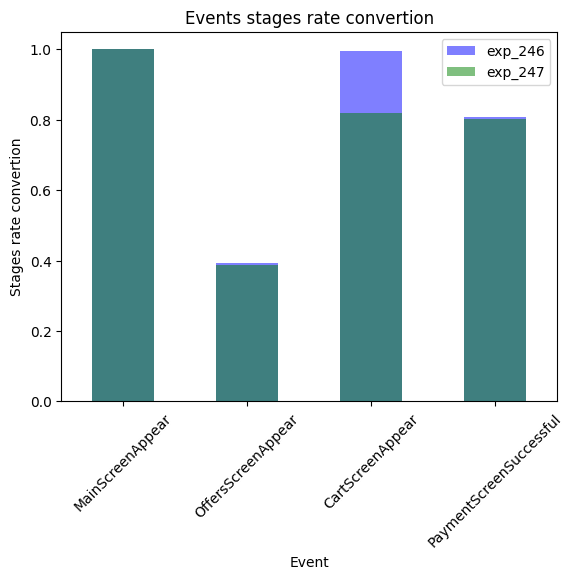

In [56]:
#Definición del tamaño para el gráfico
plt.figure(figsize = (10,6))

#Generación del gráfico
plt.figure(figsize=(12, 6))


ax = convertion_rates_246_247.plot(kind = 'bar', x = 'event', y = 'stages_convertion_rate_246', color = 'blue', label = 'exp_246', alpha = 0.5)

convertion_rates_246_247.plot(kind = 'bar', x = 'event', y = 'stages_convertion_rate_247', label = 'exp_247', ax = ax, color  = 'green', alpha =0.5)

plt.xlabel('Event')


plt.ylabel('Stages rate convertion')


plt.title('Events stages rate convertion')


plt.xticks(rotation=45)


plt.legend()


plt.show()


Como podemos observar, la diferencia mayor en el comportamiento de los clientes en la tasa de conversión por etapas es 'CartScreenAppear', sin embargo, es necesario evaluar estadisticamente por medio de una prueba chi-cuadrado y confirmar que no son significativas dichas diferencias.

###### Prueba Chi cuadrado

In [57]:
# Crear una tabla de contingencia
contingency_table = convertion_rates_246_247[['stages_convertion_rate_246', 'stages_convertion_rate_247']]

# Realizar la prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-cuadrado: {chi2}")
print(f"p-valor: {p}")

# Interpretar el p-valor
if p < 0.05:
    print("Las diferencias en las frecuencias son estadísticamente significativas.")
else:
    print("No hay diferencias estadísticamente significativas en las frecuencias.")

Chi-cuadrado: 0.011622769547729573
p-valor: 0.9996678995694859
No hay diferencias estadísticamente significativas en las frecuencias.


La prueba de chi cuadrado para la tasa de conversion por etapa de cada evento en ambos experimentos arrojó que nuestras diferencias entre las muestras no son significativas por lo que podemos decir que nuestros clientes en la prueba A/A también tuvieron el mismo comportamiento pasando etapa por etapa.

##### Evaluación de las diferencias en la tasa de conversión total

Ahora grafiquemos los procentajes de conversión total en ambos experimentos:

<Figure size 1000x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

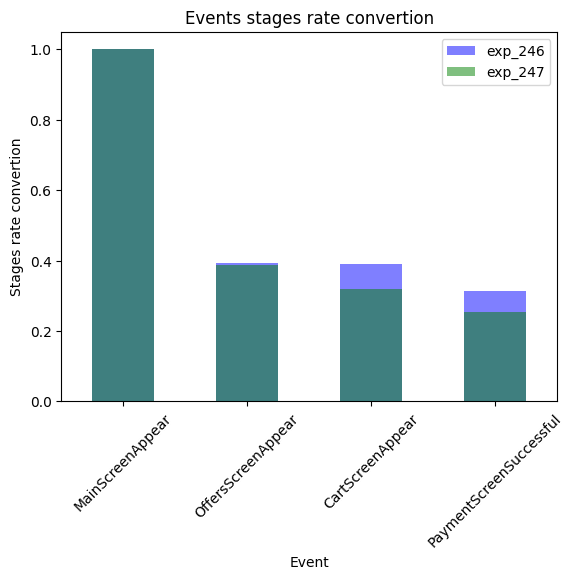

In [58]:
#Definición del tamaño para el gráfico
plt.figure(figsize = (10,6))

#Generación del gráfico
plt.figure(figsize=(12, 6))


ax = convertion_rates_246_247.plot(kind = 'bar', x = 'event', y = 'total_convertion_rate_246', color = 'blue', label = 'exp_246', alpha = 0.5)

convertion_rates_246_247.plot(kind = 'bar', x = 'event', y = 'total_convertion_rate_247', label = 'exp_247', ax = ax, color  = 'green', alpha =0.5)

plt.xlabel('Event')


plt.ylabel('Stages rate convertion')


plt.title('Events stages rate convertion')


plt.xticks(rotation=45)


plt.legend()


plt.show()


Como podemos observar, la diferencia mayor en el comportamiento de los clientes en la tasa de conversión por etapas es 'CartScreenAppear' y 'PaymentScreenSuccessful', sin embargo, es necesario evaluar estadisticamente por medio de una prueba chi-cuadrado y confirmar que no son significativas dichas diferencias.

###### Prueba Chi cuadrado

In [59]:
# Crear una tabla de contingencia
contingency_table = convertion_rates_246_247[['total_convertion_rate_246', 'total_convertion_rate_247']]

# Realizar la prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-cuadrado: {chi2}")
print(f"p-valor: {p}")

# Interpretar el p-valor
if p < 0.05:
    print("Las diferencias en las frecuencias son estadísticamente significativas.")
else:
    print("No hay diferencias estadísticamente significativas en las frecuencias.")

Chi-cuadrado: 0.008999342029182358
p-valor: 0.9997735549999526
No hay diferencias estadísticamente significativas en las frecuencias.


La prueba de chi cuadrado para la tasa de conversión total en ambos experimentos arrojó que nuestras diferencias entre las muestras no son significativas.

### Evaluación de la prueba A/A/B

#### Definición del nivel de significancia

Dado que tenemos una prueba multiple, tenemos que ajustar nuestro nivel de significancia en base a la cantidad de comparaciones que tenemos, dado que nuestras comparaciones son independientes por tratarse de grupos con personas distintas, haremos uso del método de Sidak para asignar nuestro alpha, estableciendolo con un valor inicial del 5%. Las comparaciones que realizaremos son las siguientes:

                                            1. Frecuencia de eventos:
                                                246 vs 248 (chi cuadrado)
                                                247 vs 248 (chi cuadrado)
                                            2. Duración de la sesión:
                                                246 vs 248 (Shapiro, Levene o t-test)
                                                247 vs 248 (Shapiro, Levene o t-test)
                                            3. Tasas de conversión por etapa:
                                                246 vs 248 (chi cuadrado)
                                                247 vs 248 (chi cuadrado)
                                            4. Tasas de conversión total:
                                                246 vs 248 (chi cuadrado)
                                                247 vs 248 (chi cuadrado)

Esto suma un total de 8 comparaciones.


In [60]:
# Nivel de significancia inicial
alpha = 0.05

# Número de comparaciones
m = 8

# Calcular el nivel de significancia ajustado usando el método de Šidák
alpha_sidak = 1 - (1 - alpha) ** (1 / m)

print(f'El nivel de significancia ajustado usando el método de Šidák es: {alpha_sidak:.5f}')

El nivel de significancia ajustado usando el método de Šidák es: 0.00639


Éste valor para el alpha ajustado mediante el método Sidak, será utilizado para cada una de las comparaciones entre experimentos. 

#### Experimento 246 vs experimento 248

Para evaluar diferencias entre las muestras 246 y 248 podemos enfocarnos en:

* Promedios de eventos: Comparar los promedios de los valores de eventos entre las dos muestras.

* Duración de la actividad: Calcular la duración de la actividad para cada usuario y compararlas entre las dos muestras.

* Tasas de conversión por etapa y total

In [61]:
#Filtrar dataframe para el experimento 248
experiment_248_df = events_filtered[events_filtered['exp_id'] == 248]

Ahora debemos comprobar el tamaño de registros para cada uno de los experimentos:

In [62]:
# Imprimir cantidad de usuarios para el experimento 246
print('La cantidad de usuarios para el experimento 246 es de:', experiment_246_df['user_id'].nunique())

# Imprimir cantidad de usuarios para el experimento 248
print('La cantidad de usuarios para el experimento 248 es de:', experiment_248_df['user_id'].nunique())

# Calcula la diferencia porcentual en el tamaño de las muestras
diferencia_porcentual = ((1 - (experiment_246_df['user_id'].nunique() / experiment_248_df['user_id'].nunique())) * 100)

# Imprime el resultado
print('La diferencia porcentual en el tamaño de las muestras es del:', diferencia_porcentual, '%')


La cantidad de usuarios para el experimento 246 es de: 2484
La cantidad de usuarios para el experimento 248 es de: 2537
La diferencia porcentual en el tamaño de las muestras es del: 2.089081592432007 %


##### Frecuencia  de eventos

Al no contar con la misma cantidad de datos en los dos dataframes, debemos analizar los procentajes de cada evento sobre el total de inforamción contenida en cada tabla filtrada y así determinar si existe una diferencia significativa. 

In [63]:
#Encontrar la frecuencia de eventos para el experimento 247
events_freq_248 = experiment_248_df.groupby('event', as_index = False).agg(event_cnt = ('event','count')).sort_values('event_cnt',
                                                                                                                     ascending = False)

In [64]:
# Crear una tabla de contingencia
exps_info = pd.merge(events_freq_246, events_freq_248, on='event', suffixes=('_exp_246', '_exp_248'))

#Columna con porcentaje de eventos para el experimento 246
exps_info['events_percent_246'] = (exps_info['event_cnt_exp_246'] /  experiment_246_df.shape[0]) * 100

#Columna con porcentaje de eventos para el experimento 247
exps_info['events_percent_248'] = (exps_info['event_cnt_exp_248'] /  experiment_248_df.shape[0]) * 100

<Figure size 1400x800 with 0 Axes>

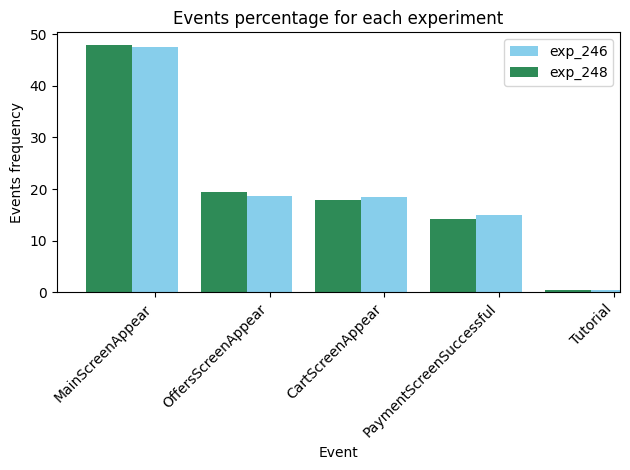

In [65]:
# Definición del tamaño para el gráfico
plt.figure(figsize=(14, 8))

# Generación del gráfico con dos barras por 'event'
ax = exps_info.plot(kind='bar', x='event', y='events_percent_246', color='skyblue', label='exp_246', position= 0.5, width=0.4)
exps_info.plot(kind='bar', x='event', y='events_percent_248', color='seagreen', label='exp_248', position=1.5, width=0.4, ax=ax)

# Configuración de etiquetas eje 'x'
plt.xlabel('Event')

# Configuración de etiquetas eje 'y'
plt.ylabel('Events frequency')

# Configuración de etiquetas para titulo
plt.title('Events percentage for each experiment')

# Ajuste de la rotación y alineación de las etiquetas del eje x
plt.xticks(rotation=45, ha='right')

#Configurar leyenda
plt.legend()

# Ajuste de los márgenes para mejorar la legibilidad
plt.tight_layout()

# Mostrar el gráfico
plt.show()


Como podemos observar en la gráfica, tenemos difrencias que parecieran no ser de mayor importancia, sin embargo, debemos realizar una prueba estadística para determinarlo. La prueba estadística adecuada para comparar frecuencias entre dos muestras es la prueba 'chi-cuadrado'.

Los números del experimento 248 parecen atraer a un poco mas de personas a visitar la página principal y las ofertas, sin embargo, las personas de éste experimento no superan la cantidad de personas que agrega al carrito y compra con éxito.

In [66]:
#Contar el número de usuarios que realizaron el evento 'MainScreenAppear' en el experimento 246
msa_cnt_246 = experiment_246_df[experiment_246_df['event'] == 'MainScreenAppear']['user_id'].nunique()

#Contar el número de usuarios que realizaron el evento 'MainScreenAppear' en el experimento 247
msa_cnt_248 = experiment_248_df[experiment_248_df['event'] == 'MainScreenAppear']['user_id'].nunique()

#Imprimir resultados para experimento 246
print('La cantidad de usuarios que realizaron el evento principal en el exp 246 es:', msa_cnt_246)

#Imprimir resultados para experimento 248
print('La cantidad de usuarios que realizaron el evento principal en el exp 248 es:', msa_cnt_248)

La cantidad de usuarios que realizaron el evento principal en el exp 246 es: 2450
La cantidad de usuarios que realizaron el evento principal en el exp 248 es: 2493


###### Prueba Chi cuadrado

In [67]:
# Crear una tabla de contingencia
contingency_table = exps_info[['events_percent_246', 'events_percent_248']]

# Realizar la prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-cuadrado: {chi2}")
print(f"p-valor: {p}")

# Interpretar el p-valor
if p < alpha_sidak:
    print("Las diferencias en las frecuencias son estadísticamente significativas.")
else:
    print("No hay diferencias estadísticamente significativas en las frecuencias.")

Chi-cuadrado: 0.04120527648846005
p-valor: 0.9997906583085601
No hay diferencias estadísticamente significativas en las frecuencias.


La prueba de chi cuadrado para las proporciones de cada evento en ambos experimentos arrojó que nuestras diferencias entre las muestras no son significativas, por lo que en cuanto a la frecuencia de eventos, dicho experimento no tuvo influencia en el comportamiento de los clientes.

##### Duración de la actividad por usuario

###### Experimento 248

In [68]:
#Agrupar por cada usuario y por cada fecha para obtener cada sesion
exp_248_sessions = experiment_248_df.groupby(['user_id','event_date'], as_index = False).agg(
    min_time = ('event_hour','min'), max_time = ('event_hour','max'), exp_id = ('exp_id','max'))

#Cambiar al tipo datetime la columna 'min_time'
exp_248_sessions['max_time'] = pd.to_datetime(exp_248_sessions['max_time'], format='%H:%M:%S')

#Cambiar al tipo datetime la columna 'max_time'
exp_248_sessions['min_time'] = pd.to_datetime(exp_248_sessions['min_time'], format='%H:%M:%S')

In [69]:
#Columna con la duración de las sesiones diarias por cada usuario en el exp 248
exp_248_sessions['session_duration'] = (exp_248_sessions['max_time'] - exp_248_sessions['min_time']).dt.seconds

###### Distribución de la duración de las sesiones en los experimentos

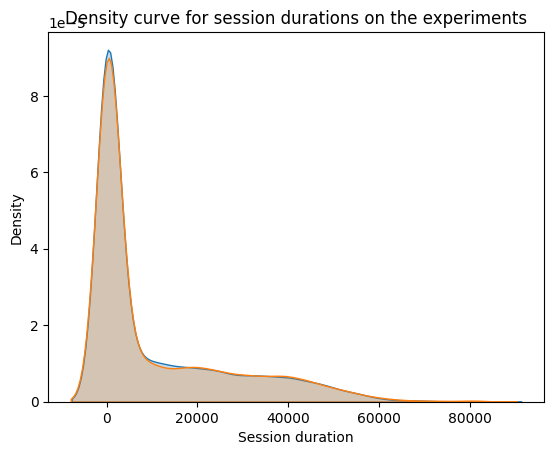

In [70]:
#Generación del histograma de densidad para el experimento 246
sns.kdeplot(exp_246_sessions['session_duration'], fill=True)

#Generación del histograma de densidad para el experimento 247
sns.kdeplot(exp_248_sessions['session_duration'], fill=True)

#Etiqueta eje x
plt.xlabel("Session duration")

#Etiqueta eje y 
plt.ylabel("Density")

#Título del gráfico
plt.title("Density curve for session durations on the experiments")

#Mostrar gráfico
plt.show()

Como podemos ver, la duración de los usuarios en las sesiones diarias es prácticamente la misma, por lo que podemos asegurar que no presentan diferencias significativas en éste comportamiento, para asegurarnos de esto podemos realizar una prueba estadística con 'ttest_ind' o de Levene.

###### Prueba de Shapiro

Para asegurarnos de que las diferencias sean o no significativas primero debemos asegurar que su distribución sea del tipo normal con una prueba de Shapiro. En la evaluación de la prueba A/A obtuvimos que la distribución para el experimento 246 NO es normal, por lo tanto, solo queda evaluar el experimento 248.

In [71]:
# Prueba de normalidad Shapiro-Wilk para el experimento 248
# nivel de significación
alpha = .05 

results = st.shapiro(exp_248_sessions['session_duration'].sample(5000)) 

# el segundo valor en la matriz de resultados (con índice 1) - el valor p 
p_value = results[1]

print('p-value: ', p_value) 

if (p_value < alpha): 
    print("Hipótesis nula rechazada: la distribución para el experimento 248 no es normal")
else: 
    print("No se pudo rechazar la hipótesis nula: la distribución para el experimento 248 parece ser normal")


p-value:  0.0
Hipótesis nula rechazada: la distribución para el experimento 248 no es normal


Dado que muestras no presentaron una distribución normal, debemos aplicar una prueba de Levene para saber si existe una diferencia significativa entre la duracion de las sesiones para cada experimento.

###### Prueba de Levene

La prueba de Levene se llevará a cabo con los siguientes parámetros:

                                * H0: La varianza de la muestra 246 = La varianza de la muestra 248
                                * H1: La varianza de la muestra 246 != La varianza de la muestra 248
                                * alpha = 0.639%

In [72]:
#Realizar prueba de Levene
results_lev = st.levene(exp_246_sessions['session_duration'].sample(5000), exp_248_sessions['session_duration'].sample(5000))

#Comparación del valor p con alpha
if results_lev.pvalue < alpha_sidak:
    print('Rechazamos la hipótesis nula: Las varianzas de las dos poblaciones son diferentes, hay una diferencia significativa.')
else:
    print('No podemos rechazar la hipótesis nula: Las varianzas de las dos poblaciones son iguales, NO hay una diferencia significativa.')

No podemos rechazar la hipótesis nula: Las varianzas de las dos poblaciones son iguales, NO hay una diferencia significativa.


Ahora que sabemos que las varianzas no presentan una diferencia significativa, podemos concluir que los usuarios en ambos experimentos tuvieron un comportamiento similar y casi igual al momento de visitar nuestra aplicación durante los días.


##### Tasas de conversión

Finalmente, debemos comparar los experimentos 246 y 248 en base a sus tasas de conversión.

###### Experimento 248

In [73]:
# Filtrar los eventos para excluir 'Tutorial'
exp_248_funnel = events_freq_248[events_freq_248['event'] != 'Tutorial']

# Resetear el índice
exp_248_funnel = exp_248_funnel.reset_index(drop=True)

In [74]:
# Inicializar la nueva columna con valores NaN
exp_248_funnel['stages_convertion_rate_248'] = float('NaN')

# Calcular el porcentaje de conversión usando un ciclo for
for i in range(1, len(exp_248_funnel)):
    exp_248_funnel.loc[i, 'stages_convertion_rate_248'] = exp_248_funnel.loc[i, 'event_cnt'] / exp_248_funnel.loc[i-1, 'event_cnt']
    
#Calcular el porcentaje de conversión total usando un ciclo for
for i in range(1, len(funnel_events)):
    exp_248_funnel.loc[i, 'total_convertion_rate_248'] = exp_248_funnel.loc[i, 'event_cnt'] / exp_248_funnel.loc[0, 'event_cnt']

# Reemplazar NaN en la columna 'conversion_rate' con 1.00
exp_248_funnel['stages_convertion_rate_248'].fillna(1.00, inplace=True)

# Reemplazar NaN en la columna 'total_conversion_rate' con 1.00
exp_248_funnel['total_convertion_rate_248'].fillna(1.00, inplace=True)

#Mostrar dataframe actualizado
exp_248_funnel

event  event_cnt  stages_convertion_rate_248  \
0         MainScreenAppear      40562                    1.000000   
1       OffersScreenAppear      16387                    0.403999   
2         CartScreenAppear      15179                    0.926283   
3  PaymentScreenSuccessful      12085                    0.796166   

   total_convertion_rate_248  
0                   1.000000  
1                   0.403999  
2                   0.374217  
3                   0.297939

Para evaluar si existe una diferencia en las tasas de conversión total y por cada etapa, debemos generar un dataframe donde tengamos ésta inforamción.

In [75]:
#Unir información de las tasas de conversión de los experimentos 246 y 248
convertion_rates_246_248 = pd.merge(exp_246_funnel, exp_248_funnel, on='event', suffixes=('_exp_246', '_exp_248'))

#Eliminar columnas que contienen la frecuencia de cada evento
convertion_rates_246_248.drop(['event_cnt_exp_246','event_cnt_exp_248'], axis = 1, inplace = True)

###### Evaluación de las diferencias en la tasa de conversión por etapas

Ahora grafiquemos los procentajes de conversión por cada etapa en ambos experimentos:

<Figure size 1000x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

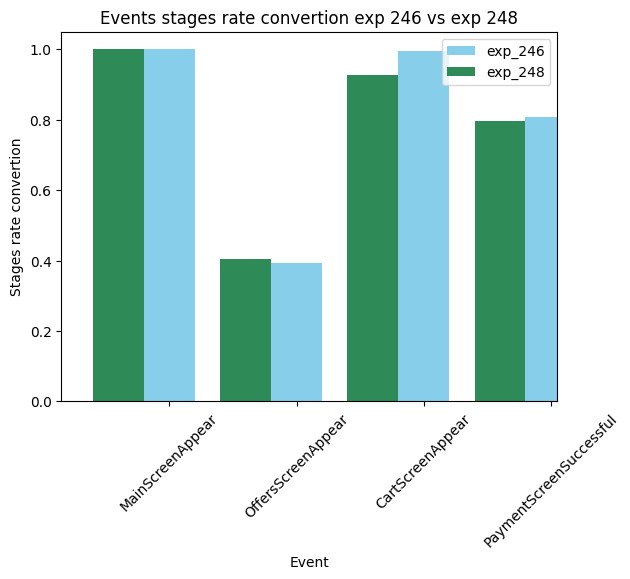

In [76]:
#Definición del tamaño para el gráfico
plt.figure(figsize = (10,6))

#Generación del gráfico
plt.figure(figsize=(12, 6))


ax = convertion_rates_246_248.plot(kind = 'bar', x = 'event', y = 'stages_convertion_rate_246', color = 'skyblue', 
                                   label = 'exp_246', position = 0.5, width=0.4)

convertion_rates_246_248.plot(kind = 'bar', x = 'event', y = 'stages_convertion_rate_248', 
                              label = 'exp_248', ax = ax, color  = 'seagreen', position = 1.5, width=0.4)

plt.xlabel('Event')


plt.ylabel('Stages rate convertion')


plt.title('Events stages rate convertion exp 246 vs exp 248')


plt.xticks(rotation=45)


plt.legend()


plt.show()


Como podemos observar, en las tasas de conversión por cada etapa, el experimento 248 obtuvo peores resultados que el exp 246, para confirmar que existe una diferencia significativa entre ambos realizaremos nuevamente una prueba estadística de chi cuadrado.

###### Prueba Chi cuadrado

In [77]:
# Crear una tabla de contingencia
contingency_table = convertion_rates_246_248[['stages_convertion_rate_246', 'stages_convertion_rate_248']]

# Realizar la prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-cuadrado: {chi2}")
print(f"p-valor: {p}")

# Interpretar el p-valor
if p < alpha_sidak:
    print("Las diferencias en las frecuencias son estadísticamente significativas.")
else:
    print("No hay diferencias estadísticamente significativas en las frecuencias.")

Chi-cuadrado: 0.001983807466770525
p-valor: 0.9999765139687044
No hay diferencias estadísticamente significativas en las frecuencias.


La prueba de chi cuadrado para la tasa de conversion por etapa de cada evento en ambos experimentos 246 y 248 arrojó que nuestras diferencias entre las muestras no son significativas por lo que podemos decir que nuestros clientes en la prueba A/B también tuvieron el mismo comportamiento pasando etapa por etapa.

###### Evaluación de las diferencias en la tasa de conversión total

Ahora grafiquemos los procentajes de conversión total en ambos experimentos:

<Figure size 1200x800 with 0 Axes>

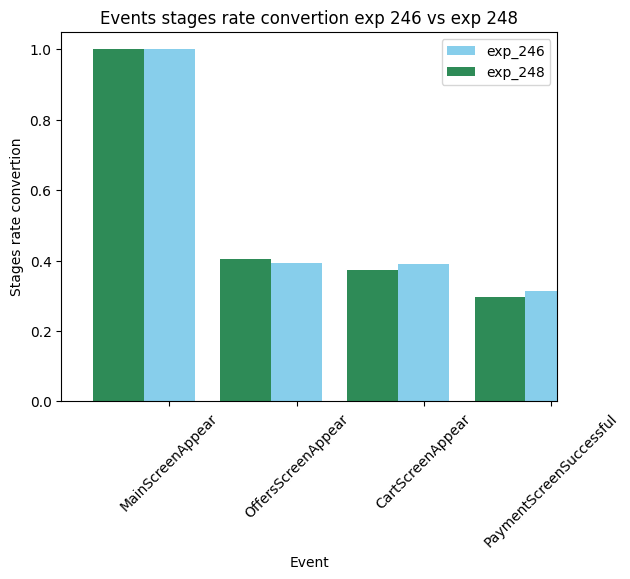

In [78]:
#Generación del gráfico
plt.figure(figsize=(12, 8))


ax = convertion_rates_246_248.plot(kind = 'bar', x = 'event', y = 'total_convertion_rate_246', color = 'skyblue', 
                                   label = 'exp_246', position = 0.5, width=0.4)

convertion_rates_246_248.plot(kind = 'bar', x = 'event', y = 'total_convertion_rate_248', 
                              label = 'exp_248', ax = ax, color  = 'seagreen', position = 1.5, width=0.4)

plt.xlabel('Event')


plt.ylabel('Stages rate convertion')


plt.title('Events stages rate convertion exp 246 vs exp 248')


plt.xticks(rotation=45)


plt.legend()


plt.show()


Como podemos observar, la diferencia en la tasa de conversión total para el experimento sigue siendo peor que el experimento 246, parece que solamente ha tenido impacto en la página de las ofertas, en las demás etapas parece no causar ningún efecto en los clientes. Evaluaremos la significancia de las diferencias con una prueba chi cuadrado.

###### Prueba Chi cuadrado

In [79]:
# Crear una tabla de contingencia
contingency_table = convertion_rates_246_248[['total_convertion_rate_246', 'total_convertion_rate_248']]

# Realizar la prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-cuadrado: {chi2}")
print(f"p-valor: {p}")

# Interpretar el p-valor
if p < alpha_sidak:
    print("Las diferencias en las frecuencias son estadísticamente significativas.")
else:
    print("No hay diferencias estadísticamente significativas en las frecuencias.")

Chi-cuadrado: 0.0008579586405187358
p-valor: 0.9999933179986957
No hay diferencias estadísticamente significativas en las frecuencias.


La prueba de chi cuadrado para la tasa de conversión total en ambos experimentos arrojó que nuestras diferencias entre las muestras no son significativas.

##### Conclusión exp 246 vs 248 

A pesar de que la alteración de las fuentes en el experimento 248 no tuvo diferencias significativas en comparación al comportamiento de las personas evaluadas en el experimento 246, si se presentaron peores resultados debido a dicha alteración en cuanto a las tasas de conversión por etapas y total, asi como en la frecuencia de los eventos, sin embargo, algo a resaltar es que las fuentes parecieran animar ligeramente a más clientes a ir desde la página principal a la página de ofertas.

#### Experimento 247 vs experimento 248

Para evaluar diferencias entre las muestras 247 y 248 podemos enfocarnos en:

* Promedios de eventos: Comparar los promedios de los valores de eventos entre las dos muestras.

* Duración de la actividad: Calcular la duración de la actividad para cada usuario y compararlas entre las dos muestras.

* Tasas de conversión por etapa y total

Ahora debemos comprobar el tamaño de registros para cada uno de los experimentos:

In [80]:
# Imprimir cantidad de usuarios para el experimento 246
print('La cantidad de usuarios para el experimento 247 es de:', experiment_247_df['user_id'].nunique())

# Imprimir cantidad de usuarios para el experimento 248
print('La cantidad de usuarios para el experimento 248 es de:', experiment_248_df['user_id'].nunique())

# Calcula la diferencia porcentual en el tamaño de las muestras
diferencia_porcentual = ((1 - (experiment_247_df['user_id'].nunique() / experiment_248_df['user_id'].nunique())) * 100)

# Imprime el resultado
print('La diferencia porcentual en el tamaño de las muestras es del:', diferencia_porcentual, '%')


La cantidad de usuarios para el experimento 247 es de: 2513
La cantidad de usuarios para el experimento 248 es de: 2537
La diferencia porcentual en el tamaño de las muestras es del: 0.9459992116673255 %


##### Frecuencia  de eventos

Al no contar con la misma cantidad de datos en los dos dataframes, debemos analizar los procentajes de cada evento sobre el total de inforamción contenida en cada tabla filtrada y así determinar si existe una diferencia significativa. 

In [81]:
# Crear una tabla de contingencia
exps_info = pd.merge(events_freq_247, events_freq_248, on='event', suffixes=('_exp_247', '_exp_248'))

#Columna con porcentaje de eventos para el experimento 246
exps_info['events_percent_247'] = (exps_info['event_cnt_exp_247'] /  experiment_247_df.shape[0]) * 100

#Columna con porcentaje de eventos para el experimento 247
exps_info['events_percent_248'] = (exps_info['event_cnt_exp_248'] /  experiment_248_df.shape[0]) * 100

<Figure size 1400x800 with 0 Axes>

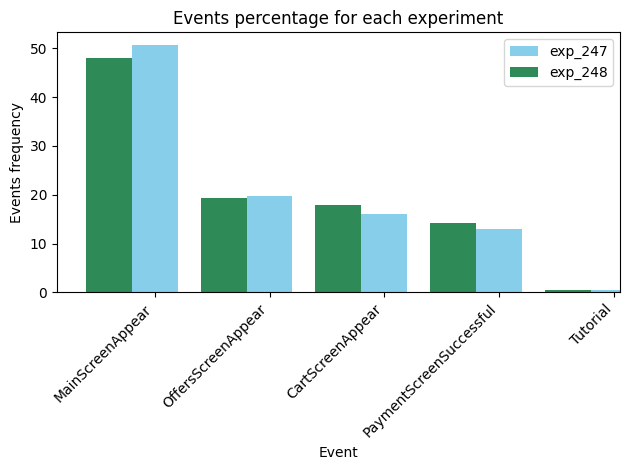

In [82]:
# Definición del tamaño para el gráfico
plt.figure(figsize=(14, 8))

# Generación del gráfico con dos barras por 'event'
ax = exps_info.plot(kind='bar', x='event', y='events_percent_247', color='skyblue', label='exp_247', position= 0.5, width=0.4)
exps_info.plot(kind='bar', x='event', y='events_percent_248', color='seagreen', label='exp_248', position=1.5, width=0.4, ax=ax)

# Configuración de etiquetas eje 'x'
plt.xlabel('Event')

# Configuración de etiquetas eje 'y'
plt.ylabel('Events frequency')

# Configuración de etiquetas para titulo
plt.title('Events percentage for each experiment')

# Ajuste de la rotación y alineación de las etiquetas del eje x
plt.xticks(rotation=45, ha='right')

#Configurar leyenda
plt.legend()

# Ajuste de los márgenes para mejorar la legibilidad
plt.tight_layout()

# Mostrar el gráfico
plt.show()


Como podemos observar en la gráfica, tenemos difrencias que parecieran no ser de mayor importancia, sin embargo, debemos realizar una prueba estadística para determinarlo. La prueba estadística adecuada para comparar frecuencias entre dos muestras es la prueba 'chi-cuadrado'.

Los números del experimento 248 parecen indicar que presentó mejores resultados en la gente que llegó a la pagina del carrito y al pago existoso, esto podremos confirmarlo al evaluar las tasas de conversión.

In [83]:
#Imprimir resultados para experimento 247
print('La cantidad de usuarios que realizaron el evento principal en el exp 247 es:', msa_cnt_247)

#Imprimir resultados para experimento 248
print('La cantidad de usuarios que realizaron el evento principal en el exp 248 es:', msa_cnt_248)

La cantidad de usuarios que realizaron el evento principal en el exp 247 es: 2476
La cantidad de usuarios que realizaron el evento principal en el exp 248 es: 2493


###### Prueba Chi cuadrado

In [84]:
# Crear una tabla de contingencia
contingency_table = exps_info[['events_percent_247', 'events_percent_248']]

# Realizar la prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-cuadrado: {chi2}")
print(f"p-valor: {p}")

# Interpretar el p-valor
if p < alpha_sidak:
    print("Las diferencias en las frecuencias son estadísticamente significativas.")
else:
    print("No hay diferencias estadísticamente significativas en las frecuencias.")

Chi-cuadrado: 0.24295076655283007
p-valor: 0.9931930148375713
No hay diferencias estadísticamente significativas en las frecuencias.


La prueba de chi cuadrado para las proporciones de cada evento en ambos experimentos arrojó que nuestras diferencias entre las muestras no son significativas, por lo que en cuanto a la frecuencia de eventos, dicho experimento no tuvo influencia en el comportamiento de los clientes.

##### Duración de la actividad por usuario

###### Distribución de la duración de las sesiones en los experimentos

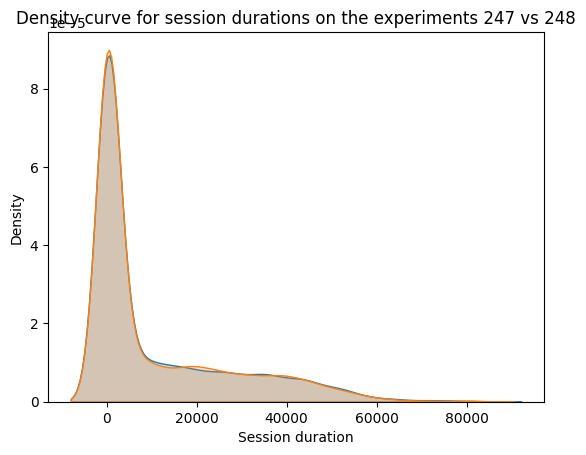

In [85]:
#Generación del histograma de densidad para el experimento 246
sns.kdeplot(exp_247_sessions['session_duration'], fill=True)

#Generación del histograma de densidad para el experimento 247
sns.kdeplot(exp_248_sessions['session_duration'], fill=True)

#Etiqueta eje x
plt.xlabel("Session duration")

#Etiqueta eje y 
plt.ylabel("Density")

#Título del gráfico
plt.title("Density curve for session durations on the experiments 247 vs 248")

#Mostrar gráfico
plt.show()

Como podemos ver, la duración de los usuarios en las sesiones diarias es prácticamente la misma, por lo que podemos asegurar que no presentan diferencias significativas en éste comportamiento, para asegurarnos de esto podemos realizar una prueba estadística con 'ttest_ind' o de Levene.

Dado que muestras no presentaron una distribución normal, debemos aplicar una prueba de Levene para saber si existe una diferencia significativa entre la duracion de las sesiones para cada experimento.

###### Prueba de Levene

La prueba de Levene se llevará a cabo con los siguientes parámetros:

                                * H0: La varianza de la muestra 247 = La varianza de la muestra 248
                                * H1: La varianza de la muestra 247 != La varianza de la muestra 248
                                * alpha = 0.639%

In [86]:
#Realizar prueba de Levene
results_lev = st.levene(exp_246_sessions['session_duration'].sample(5000), exp_248_sessions['session_duration'].sample(5000))

#Comparación del valor p con alpha
if results_lev.pvalue < alpha_sidak:
    print('Rechazamos la hipótesis nula: Las varianzas de las dos poblaciones son diferentes, hay una diferencia significativa.')
else:
    print('No podemos rechazar la hipótesis nula: Las varianzas de las dos poblaciones son iguales, NO hay una diferencia significativa.')

No podemos rechazar la hipótesis nula: Las varianzas de las dos poblaciones son iguales, NO hay una diferencia significativa.


Ahora que sabemos que las varianzas no presentan una diferencia significativa, podemos concluir que los usuarios en ambos experimentos tuvieron un comportamiento similar y casi igual al momento de visitar nuestra aplicación durante los días.


##### Tasas de conversión

Finalmente, debemos comparar los experimentos 247 y 248 en base a sus tasas de conversión.

Para evaluar si existe una diferencia en las tasas de conversión total y por cada etapa, debemos generar un dataframe donde tengamos ésta inforamción.

In [87]:
#Unir información de las tasas de conversión de los experimentos 247 y 248
convertion_rates_247_248 = pd.merge(exp_247_funnel, exp_248_funnel, on='event', suffixes=('_exp_247', '_exp_248'))

#Eliminar columnas que contienen la frecuencia de cada evento
convertion_rates_247_248.drop(['event_cnt_exp_247','event_cnt_exp_248'], axis = 1, inplace = True)

###### Evaluación de las diferencias en la tasa de conversión por etapas

Ahora grafiquemos los procentajes de conversión por cada etapa en ambos experimentos:

<Figure size 1000x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

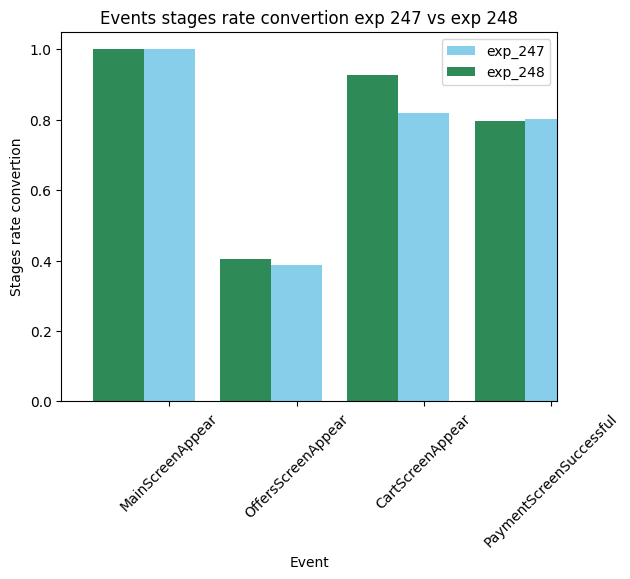

In [88]:
#Definición del tamaño para el gráfico
plt.figure(figsize = (10,6))

#Generación del gráfico
plt.figure(figsize=(12, 6))


ax = convertion_rates_247_248.plot(kind = 'bar', x = 'event', y = 'stages_convertion_rate_247', color = 'skyblue', 
                                   label = 'exp_247', position = 0.5, width=0.4)

convertion_rates_247_248.plot(kind = 'bar', x = 'event', y = 'stages_convertion_rate_248', 
                              label = 'exp_248', ax = ax, color  = 'seagreen', position = 1.5, width=0.4)

plt.xlabel('Event')


plt.ylabel('Stages rate convertion')


plt.title('Events stages rate convertion exp 247 vs exp 248')


plt.xticks(rotation=45)


plt.legend()


plt.show()


Como podemos observar, en las tasas de conversión por cada etapa, el experimento 248 obtuvo mejores resultados que el exp 246, ya que, mas personas de las que visitan la página principal llegan a las ofertas y añaden cosas a su carrito , para confirmar que existe una diferencia significativa en el comportamiento entre ambos realizaremos nuevamente una prueba estadística de chi cuadrado.

###### Prueba Chi cuadrado

In [89]:
# Crear una tabla de contingencia
contingency_table = convertion_rates_247_248[['stages_convertion_rate_247', 'stages_convertion_rate_248']]

# Realizar la prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-cuadrado: {chi2}")
print(f"p-valor: {p}")

# Interpretar el p-valor
if p < alpha_sidak:
    print("Las diferencias en las frecuencias son estadísticamente significativas.")
else:
    print("No hay diferencias estadísticamente significativas en las frecuencias.")

Chi-cuadrado: 0.004711294071068707
p-valor: 0.999914115383208
No hay diferencias estadísticamente significativas en las frecuencias.


La prueba de chi cuadrado para la tasa de conversion por etapa de cada evento en ambos experimentos 247 y 248 arrojó que nuestras diferencias entre las muestras no son significativas por lo que podemos decir que nuestros clientes en la prueba A/B también tuvieron el mismo comportamiento pasando etapa por etapa.

###### Evaluación de las diferencias en la tasa de conversión total

Ahora grafiquemos los procentajes de conversión total en ambos experimentos:

<Figure size 1200x800 with 0 Axes>

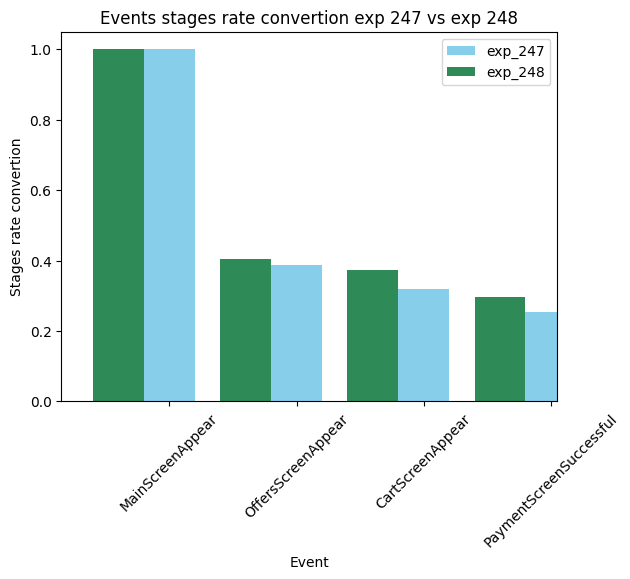

In [90]:
#Generación del gráfico
plt.figure(figsize=(12, 8))


ax = convertion_rates_247_248.plot(kind = 'bar', x = 'event', y = 'total_convertion_rate_247', color = 'skyblue', 
                                   label = 'exp_247', position = 0.5, width=0.4)

convertion_rates_247_248.plot(kind = 'bar', x = 'event', y = 'total_convertion_rate_248', 
                              label = 'exp_248', ax = ax, color  = 'seagreen', position = 1.5, width=0.4)

plt.xlabel('Event')


plt.ylabel('Stages rate convertion')


plt.title('Events stages rate convertion exp 247 vs exp 248')


plt.xticks(rotation=45)


plt.legend()


plt.show()


Como podemos observar, la diferencia en la tasa de conversión total para el experimento 248 es mejor que el experimento 247, siendo asi que tenemos mayores pagos con éxito del total de personas que visitan la página principal. Evaluaremos la significancia de las diferencias con una prueba chi cuadrado.

###### Prueba Chi cuadrado

In [91]:
# Crear una tabla de contingencia
contingency_table = convertion_rates_247_248[['total_convertion_rate_247', 'total_convertion_rate_248']]

# Realizar la prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-cuadrado: {chi2}")
print(f"p-valor: {p}")

# Interpretar el p-valor
if p < alpha_sidak:
    print("Las diferencias en las frecuencias son estadísticamente significativas.")
else:
    print("No hay diferencias estadísticamente significativas en las frecuencias.")

Chi-cuadrado: 0.0049038580358701025
p-valor: 0.9999088016849784
No hay diferencias estadísticamente significativas en las frecuencias.


La prueba de chi cuadrado para la tasa de conversión total en ambos experimentos arrojó que nuestras diferencias entre las muestras no son significativas.

##### Conclusión exp 247 vs 248

A pesar de que la alteración de las fuentes en el experimento 248 no tuvo diferencias significativas en comparación al comportamiento de las personas evaluadas en el experimento 247, auqnue si se presentó un ligero aumento en las etapas de ofertas y carrito, asi como en la frecuencia de los eventos, algo a resaltar es que las fuentes parecieran animar ligeramente a explorar la siguiente página que los usuarios del experimento 247 siendo asi que las personas que vieron las fuentes alteradas desde la página principal tuvieron mayor porcentaje de ventas (tasa de conversión total en la última fase).

#### Métricas acumuladas

Para generar un dataframe con la información agregada de la duración de las sesiones, primero debemos unir todos los datos que tenemos de los diferentes experimentos en uno solo.

In [92]:
#Concatenar los 3 dataframes con informacion de las sesiones en cada experimento
exp_sessions = pd.concat([exp_246_sessions, exp_247_sessions, exp_248_sessions], axis = 0)

exp_sessions

user_id event_date            min_time            max_time  \
0      100724994572555335 2019-08-05 1900-01-01 16:06:45 1900-01-01 16:08:43   
1     1010439893181060015 2019-08-03 1900-01-01 10:22:48 1900-01-01 10:29:53   
2     1025737506158455281 2019-08-07 1900-01-01 13:30:37 1900-01-01 15:00:31   
3     1028732925370208603 2019-08-04 1900-01-01 15:58:11 1900-01-01 16:08:21   
4     1034477367567772443 2019-08-03 1900-01-01 08:46:28 1900-01-01 08:52:10   
...                   ...        ...                 ...                 ...   
8651   992129977226956838 2019-08-07 1900-01-01 04:56:17 1900-01-01 05:01:42   
8652   992321565231279868 2019-08-03 1900-01-01 23:01:58 1900-01-01 23:15:51   
8653   992321565231279868 2019-08-05 1900-01-01 12:26:15 1900-01-01 12:26:15   
8654   993193057518949787 2019-08-06 1900-01-01 18:08:06 1900-01-01 18:22:14   
8655   995065401066914588 2019-08-04 1900-01-01 07:27:54 1900-01-01 07:29:54   

      exp_id  session_duration  
0        246               118  
1        246               425  
2        246              5394  
3        246               610  
4        246               342  
...      ...               ...  
8651     248               325  
8652     248               833  
8653     248                 0  
8654     248               848  
8655     248               120  

[25734 rows x 6 columns]

In [93]:
# crea una matriz con valores únicos de parejas fecha-grupo
date_group = exp_sessions[['event_date','exp_id']].drop_duplicates()

In [94]:
#Crear dataframe para la información (agregada) de los pedidos 
info_agg = date_group.apply(lambda x: exp_sessions[np.logical_and(exp_sessions['event_date'] <= x['event_date'], 
                                                                     exp_sessions['exp_id'] == x['exp_id'])].agg(
    {'event_date' : 'max', 'exp_id' : 'max', 'user_id' : pd.Series.nunique, 'session_duration' : 'sum'}), axis=1).sort_values(
    by=['event_date','exp_id'])

#Renombrar columna 'user_id'
info_agg.rename(columns = {'user_id':'users_cnt', 'session_duration':'cumulative_session_duration'}, inplace = True)

In [95]:
# DataFrame con sesiones acumuladas y cantidad de usuarios acumulados por día, experimento 246
cummulative_exp_246 = info_agg[info_agg['exp_id']==246][['event_date','cumulative_session_duration', 'users_cnt']]

# DataFrame con sesiones acumuladas y cantidad de usuarios acumulados por día, experimento 247
cummulative_exp_247 = info_agg[info_agg['exp_id']==247][['event_date','cumulative_session_duration', 'users_cnt']]

# DataFrame con sesiones acumuladas y cantidad de usuarios acumulados por día, experimento 248
cummulative_exp_248 = info_agg[info_agg['exp_id']==248][['event_date','cumulative_session_duration', 'users_cnt']]

##### Experimento 246 vs 248

###### Duración de las sesiones acumulado por dia

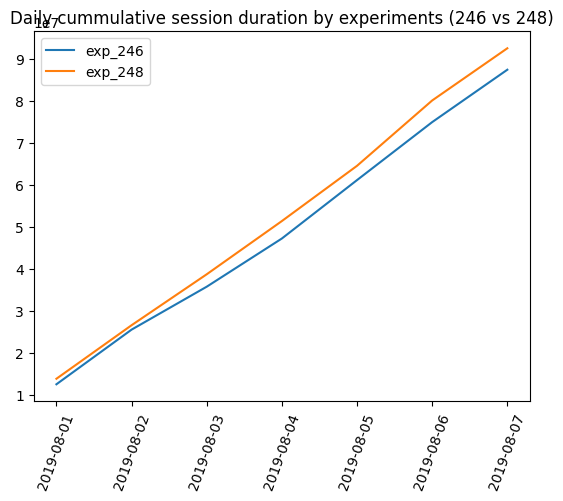

In [96]:
#Gráfico para la duración acumulada de las sesiones en el experimento 246
plt.plot(cummulative_exp_246['event_date'], cummulative_exp_246['cumulative_session_duration'], label = 'exp_246')

#Gráfico para la duración acumulada de las sesiones en el grupo 248
plt.plot(cummulative_exp_248['event_date'], cummulative_exp_248['cumulative_session_duration'], label = 'exp_248')

#Rotar etiquetas del eje 'X'
plt.xticks(rotation=70)

#Asignar titulo al gráfico
plt.title('Daily cummulative session duration by experiments (246 vs 248)')

#imprimir leyenda del gráfico
plt.legend()

Podemos apreciar en el gráfico que durante el transcurso de los días, las personas van pasando cada vez más y más tiempo en la aplicación, ambos experimentos prpesentan la misma tendencia a la alza con valores bastante similares, ninguna gráfica presenta un punto de inflexión hasta el momento.

###### Duración de las sesiones promedio (diaria) por usuario por experimento

In [97]:
#Crear columna para almacenar el promedio de las sesiones diarias experimento 246
cummulative_exp_246['duration_per_user'] = (cummulative_exp_246['cumulative_session_duration'] / cummulative_exp_246['users_cnt']).round(2)

#Crear columna para almacenar el promedio de las sesiones diarias experimento 248 
cummulative_exp_248['duration_per_user'] = (cummulative_exp_248['cumulative_session_duration'] / cummulative_exp_248['users_cnt']).round(2)

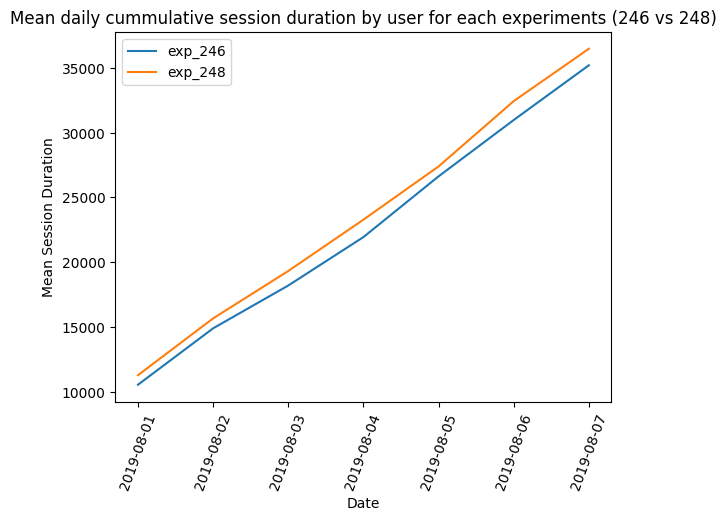

In [98]:
#Generar gráfico para las sesiones promedio en segundos del exp 246
plt.plot(cummulative_exp_246['event_date'], cummulative_exp_246['duration_per_user'], label = 'exp_246')

#Generar gráfico para las sesiones promedio en segundos del exp 248
plt.plot(cummulative_exp_248['event_date'], cummulative_exp_248['duration_per_user'], label = 'exp_248')


#Rotación de las etiquetas para el eje 'x'
plt.xticks(rotation = 70)

#Titulo del gráfico
plt.title('Mean daily cummulative session duration by user for each experiments (246 vs 248)')

#Etiqueta para el eje 'x'
plt.xlabel('Date')

#Etiqueta para el eje 'y'
plt.ylabel('Mean Session Duration')

#Mostrar leyenda del gráfico
plt.legend()

Los usuarios del experimento 248 suelen pasar mas tiempo en la aplicación que las personas del experimento 246, ambos grupos presentan una tendencia a la alza, es decir, mientras mas tiempo pasa, mas tiempo estan en la aplicación, también presentan valores muy cercanos entre sí.

###### Diferencia relativa entre experimentos de la duracion de sesiones promedio

In [99]:
#Unir 'cumulative_revenue_A' con 'cumulative_revenue_B'
cumulative_sessions = pd.merge(cummulative_exp_246, cummulative_exp_248, on = 'event_date', suffixes = ['_246','_248'])

cumulative_sessions

event_date  cumulative_session_duration_246  users_cnt_246  \
0 2019-08-01                         12562458           1191   
1 2019-08-02                         25571604           1716   
2 2019-08-03                         35793559           1966   
3 2019-08-04                         47268093           2154   
4 2019-08-05                         61174590           2297   
5 2019-08-06                         74977539           2420   
6 2019-08-07                         87450642           2484   

   duration_per_user_246  cumulative_session_duration_248  users_cnt_248  \
0               10547.82                         13879474           1230   
1               14901.87                         26621899           1699   
2               18206.29                         38751046           2005   
3               21944.33                         51421517           2208   
4               26632.39                         64574570           2357   
5               30982.45                         80128708           2470   
6               35205.57                         92555278           2537   

   duration_per_user_248  
0               11284.13  
1               15669.16  
2               19327.20  
3               23288.73  
4               27396.93  
5               32440.77  
6               36482.18

In [100]:
#Crear columna para la diferencia relativa entre experimentos
cumulative_sessions['relative_difference'] = (cumulative_sessions['duration_per_user_248'] / cumulative_sessions['duration_per_user_246'])-1

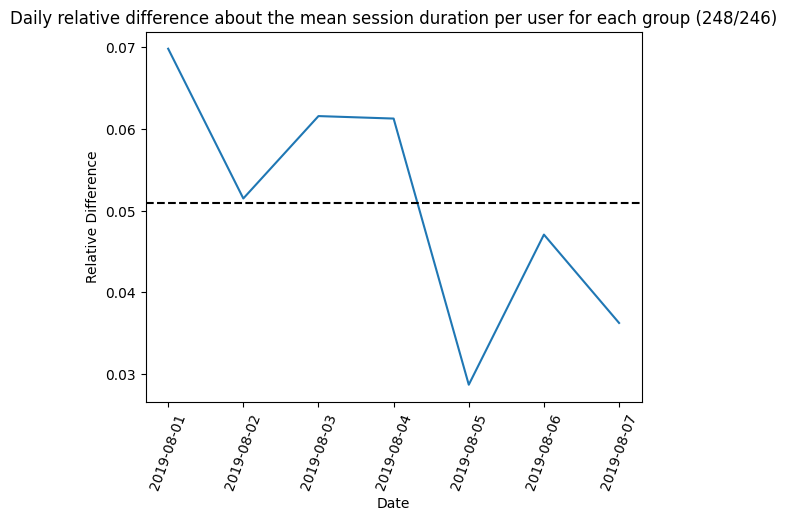

In [101]:
#Generar gráfico para la diferencia relativa
plt.plot(cumulative_sessions['event_date'], cumulative_sessions['relative_difference'])

#Rotar etiquetas para el eje 'x'
plt.xticks(rotation = 70)

#Titulo del gráfico
plt.title('Daily relative difference about the mean session duration per user for each group (248/246)')

#Etiqueta para el eje 'x'
plt.xlabel('Date')

#Etiqueta para el eje 'y'
plt.ylabel('Relative Difference')

#Generar linea discontinua para visualizar la media
plt.axhline(y= cumulative_sessions['relative_difference'].mean() , color='black', linestyle='--')

#Mostrar gráfico
plt.show()

Éste gráfico nos arroja inforamción sobre la diferencia relativa que existe entre las duraciones promedio de los usuarios dia a dia, reflejando que apesar de no existir diferencias significativas en los valores (análisis anterior mediante pruebas estadísticas), en realidad los resultados de dicho experimento están siendo positivos en comparación al experimento 246, ya que los usuarios pasan mas tiempo en la aplicación. Sin embargo, podemos encontrar una tendencia a la baja en dicho comportamiento, de momento no podemos sacar conclusiones definitivas debido a que la gráfica aún no es estable.

##### Experimento 247 vs 248

###### Duración de las sesiones acumulado por dia

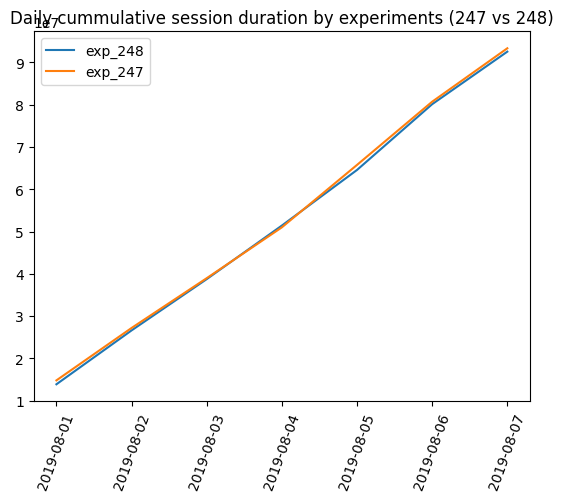

In [102]:
#Gráfico para la duración acumulada de las sesiones en el experimento 247
plt.plot(cummulative_exp_248['event_date'], cummulative_exp_248['cumulative_session_duration'], label = 'exp_248')

#Gráfico para la duración acumulada de las sesiones en el grupo 248
plt.plot(cummulative_exp_247['event_date'], cummulative_exp_247['cumulative_session_duration'], label = 'exp_247')

#Rotar etiquetas del eje 'X'
plt.xticks(rotation=70)

#Asignar titulo al gráfico
plt.title('Daily cummulative session duration by experiments (247 vs 248)')

#imprimir leyenda del gráfico
plt.legend()

Podemos apreciar en el gráfico que durante el transcurso de los días, las personas van pasando cada vez más y más tiempo en la aplicación, ambos experimentos presentan un comportamiento casi identico.

###### Duración de las sesiones promedio (diaria) por usuario por experimento

In [103]:
#Crear columna para almacenar el promedio de las sesiones diarias experimento 247
cummulative_exp_247['duration_per_user'] = (cummulative_exp_247['cumulative_session_duration'] / cummulative_exp_247['users_cnt']).round(2)

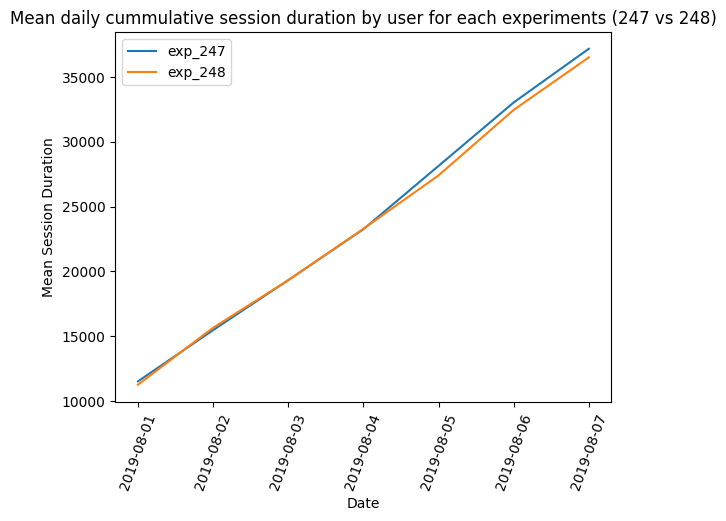

In [104]:
#Generar gráfico para las sesiones promedio en segundos del exp 246
plt.plot(cummulative_exp_247['event_date'], cummulative_exp_247['duration_per_user'], label = 'exp_247')

#Generar gráfico para las sesiones promedio en segundos del exp 248
plt.plot(cummulative_exp_248['event_date'], cummulative_exp_248['duration_per_user'], label = 'exp_248')


#Rotación de las etiquetas para el eje 'x'
plt.xticks(rotation = 70)

#Titulo del gráfico
plt.title('Mean daily cummulative session duration by user for each experiments (247 vs 248)')

#Etiqueta para el eje 'x'
plt.xlabel('Date')

#Etiqueta para el eje 'y'
plt.ylabel('Mean Session Duration')

#Mostrar leyenda del gráfico
plt.legend()

Los usuarios del experimento 248 suelen pasar mas tiempo en la aplicación que las personas del experimento 247, ambos grupos presentan una tendencia a la alza, es decir, mientras mas tiempo pasa, mas tiempo estan en la aplicación, también presentan valores muy cercanos entre sí.

###### Diferencia relativa entre experimentos de la duracion de sesiones promedio

In [105]:
#Unir los dataframe acumulados del exp 247 y 248
cumulative_sessions = pd.merge(cummulative_exp_247, cummulative_exp_248, on = 'event_date', suffixes = ['_247','_248'])

cumulative_sessions

event_date  cumulative_session_duration_247  users_cnt_247  \
0 2019-08-01                         14801513           1282   
1 2019-08-02                         27199043           1756   
2 2019-08-03                         38977871           2016   
3 2019-08-04                         50998882           2193   
4 2019-08-05                         65766975           2338   
5 2019-08-06                         80716941           2445   
6 2019-08-07                         93350852           2513   

   duration_per_user_247  cumulative_session_duration_248  users_cnt_248  \
0               11545.64                         13879474           1230   
1               15489.20                         26621899           1699   
2               19334.26                         38751046           2005   
3               23255.30                         51421517           2208   
4               28129.59                         64574570           2357   
5               33013.06                         80128708           2470   
6               37147.18                         92555278           2537   

   duration_per_user_248  
0               11284.13  
1               15669.16  
2               19327.20  
3               23288.73  
4               27396.93  
5               32440.77  
6               36482.18

In [106]:
#Crear columna para la diferencia relativa entre experimentos
cumulative_sessions['relative_difference'] = (cumulative_sessions['duration_per_user_248'] / cumulative_sessions['duration_per_user_247'])-1

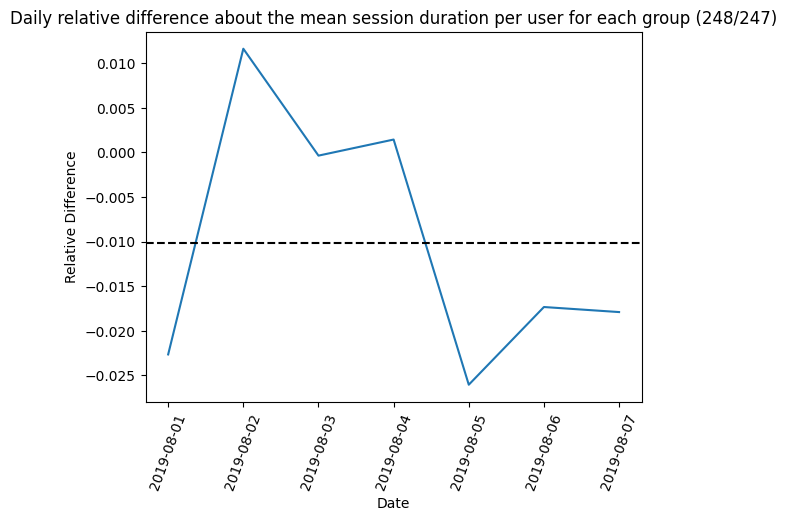

In [107]:
#Generar gráfico para la diferencia relativa
plt.plot(cumulative_sessions['event_date'], cumulative_sessions['relative_difference'])

#Rotar etiquetas para el eje 'x'
plt.xticks(rotation = 70)

#Titulo del gráfico
plt.title('Daily relative difference about the mean session duration per user for each group (248/247)')

#Etiqueta para el eje 'x'
plt.xlabel('Date')

#Etiqueta para el eje 'y'
plt.ylabel('Relative Difference')

#Generar linea discontinua para visualizar la media
plt.axhline(y= cumulative_sessions['relative_difference'].mean() , color='black', linestyle='--')

#Mostrar gráfico
plt.show()

Éste gráfico nos arroja inforamción sobre la diferencia relativa que existe entre las duraciones promedio de los usuarios dia a dia, reflejando que apesar de no existir diferencias significativas en los valores (análisis anterior mediante pruebas estadísticas), en realidad los resultados de dicho experimento tienen bastante fluctuación, siendo asi que dicha comparación presenta mejorías y empeoramiento, no se observa una tendencia clara de momento. Sin embargo, aun no podemos sacar conclusiones definitivas, ya que, la gráfica aún no es estable.

## CONCLUSIÓNES DESGLOZADAS

De forma general, no se encontraron diferencias significativas en el comportamiento de los clientes entre los grupos A, lo que sugiere que no hay factores externos distorsionando los resultados. En general, el evento con menos registros es el tutorial, indicando que pocos usuarios lo utilizan pero al mismo tiempo es el evento con más usuarios únicos, sugiriendo que quienes lo usan aprenden rápidamente.
‘MainScreenAppear’ tiene la mayor frecuencia, mostrando que los usuarios acceden directamente a la página principal de los cuales aproximadamente el 50% de todos los usuarios que visitan la página principal completan una compra (tasa de conversión total). Sin embargo, la pantalla de pago tiene una gran cantidad de usuarios con una única visita, lo que podría indicar que no vuelven a comprar. 
También existe una disminución significativa en la conversión entre la página principal y la página de ofertas, lo que sugiere que las ofertas pueden no ser atractivas o hay problemas de navegación. Las tasas de conversión mejoran a partir de la página de ofertas, indicando que son bien recibidas por quienes las ven. Sin embargo, la tasa de conversión total sugiere problemas en la etapa de pago o falta de convencimiento por las ofertas, llevando a los usuarios a abandonar el proceso. Es crucial investigar las razones detrás de la baja conversión inicial y los problemas en la etapa de pago para mejorar la experiencia del usuario y aumentar la tasa de conversión total.

La comparación del experimento 246 y 248 arrojaron que, aunque la alteración de las fuentes en el experimento 248 no mostró diferencias significativas en el comportamiento general comparado con el experimento 246, sí afectó negativamente las tasas de conversión y la frecuencia de eventos. Sin embargo, las fuentes parecen incentivar a más usuarios a visitar la página de ofertas desde la página principal. A pesar de esto, los usuarios del experimento 248 pasan más tiempo en la aplicación, mostrando una tendencia al alza similar a la del experimento 246, aunque aún no se pueden sacar conclusiones definitivas debido a la inestabilidad de los datos actuales. Esto no necesariamente puede ser algo positivo, porque puede que al cambiar las fuentes, los usuarios se sientan 'perdidos' al usar la aplicación por verla con un formato cambiado y por ello terminen avandonando el proceso, impactando en las tasas de conversión.

La comparación del experimento 247 y 248 arrojaron que, en el experimento 248, se observó un ligero aumento en las etapas de ofertas y carrito, así como en la frecuencia de eventos. Esto sugiere que los usuarios del experimento 248, que vieron las fuentes alteradas, estaban más inclinados a explorar la siguiente página en comparación con los usuarios del experimento 247. Los usuarios del experimento 248 mostraron una mayor tasa de conversión total, con un mayor porcentaje de ventas exitosas desde la página principal hasta el pago final. Estos comportamientos indican que las fuentes alteradas en el experimento 248 podrían haber incentivado a los usuarios a interactuar más con la página y avanzar en el proceso de compra. Sin embargo, debido a la fluctuación en los resultados, estas observaciones aún no son concluyentes.

## CONCLUSIÓN GENERAL

En general, no se encontraron diferencias significativas en el comportamiento de los clientes entre los grupos A (246 y 247), lo que sugiere que no hay factores externos distorsionando los resultados. El evento con menos registros es el tutorial, indicando que pocos usuarios lo utilizan, pero es el evento con más usuarios únicos, sugiriendo que quienes lo usan aprenden rápidamente. Los usuarios suelen ingresar directamente a la página principal, de los cuales aproximadamente el 50% llegan a la pantalla de pago. Sin embargo, esta pantalla tiene una gran cantidad de usuarios con una única visita, lo que podría indicar que no vuelven a comprar. También existe una disminución significativa en la conversión entre la página principal y la página de ofertas, lo que sugiere que las ofertas pueden no ser atractivas o hay problemas de navegación.

El análisis de comparación entre los experimentos arrojó que:

    *La alteración de las fuentes en el experimento 248 mostró efectos mixtos. Comparado con los experimentos 246 y 247, aunque no hubo diferencias significativas en el comportamiento general, se observó una disminución en las tasas de conversión y la frecuencia de eventos en comparación con el experimento 246. Sin embargo, los usuarios del experimento 248 pasaron más tiempo en la aplicación y mostraron una mayor inclinación a visitar la página de ofertas y avanzar en el proceso de compra, lo que resultó en una mayor tasa de conversión total en comparación con el experimento 247.

    *A pesar de estos hallazgos, los resultados aún no son concluyentes debido a la inestabilidad de los datos actuales. Además, al graficar la diferencia relativa en cada una de las comparaciones, se observa una tendencia negativa en cuanto a la cantidad de tiempo que los usuarios pasan en la aplicación. Esto podría indicar que los usuarios del experimento 248 están comenzando a familiarizarse con el nuevo formato y les está pareciendo más atractivo, ya que compran más en menos tiempo.

    *De esta manera, se aclara que aunque hay una tendencia negativa en el tiempo de sesión, esto podría interpretarse como una mayor eficiencia en el proceso de compra debido a la familiarización con el nuevo formato.
    
NOTA: No se recomienda parar la prueba debido a que las métricas acumuladas no presentan una tendencia clara ni estable, hace falta más información para confirmar las conclusiones sacadas sobre el comportamiento de los clientes y si el impacto en el cambio de las fuentes fue significativamente positivo o no.